### Insurance Reviews

This dataset contains reviews published by insurance customers. There are different
columns
- date: it contains the date of the publication of the review and the period of the review
experience, and it has to be cleaned.
- note: it is the number of stars given by the customer (it should be predicted in the test
dataset)
- auteur: the id of the customer
- avis: the review
- assureur: the name of the insurance
- produit: the type of insurance

### Import libraries

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None 
#!pip install dateparser
import re
import datetime
import dateparser
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import warnings
import plotly.io as pio
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')
import re
import string
import nltk
import spacy
from spacy_lefff import LefffLemmatizer, POSTagger
from spacy.language import Language
from nltk.corpus import stopwords
from spacy.lang.fr.stop_words import STOP_WORDS as fr_stop
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk.stem.snowball import FrenchStemmer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from gensim import corpora, models
import feedparser
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

### Reading the dataset

In [2]:
df = pd.read_csv(r"avisassurance_train.csv", sep = ';')

In [3]:
df

date  note  \
0                                           06 septem...     5   
1                                           03 mai 20...     4   
2                                           21 mars 2...     5   
3                                           10 juin 2...     4   
4                                           29 janvie...     1   
...                                                  ...   ...   
24100                                       22 mars 2...     1   
24101                                       06 décemb...     1   
24102                                       14 avril ...     1   
24103                                       11 juille...     3   
24104                                       19 janvie...     1   

                  auteur                                               avis  \
0       brahim--k-131532  Meilleurs assurances, prix, solutions, écoute,...   
1       bernard-g-112497  je suis globalement satisfait , sauf que vous ...   
2      virginie-t-107352  Prix tres abordable plusieurs options s'offren...   
3       boulain-f-116580  je satisfait du service, une réponse très rapi...   
4        ouaille31-51798  Client depuis plus de 25 ans, très déçu de cet...   
...                  ...                                                ...   
24100      hophop-107522  Assurance moto chez la mutuel des motards en F...   
24101          tzl-81680  Même les demandes les plus simples n'aboutisse...   
24102   jmr-72500-110395  En décembre 2019, j'ai souscrit à un contrat C...   
24103         cris-77532  Je suis assurer à la gmf depuis plus de 15 ans...   
24104        jesse-51459  Bonjour\r\nMon ami vient de se faire voler sa ...   

                   assureur     produit  
0          Direct Assurance        auto  
1          Direct Assurance        auto  
2          Direct Assurance        auto  
3       L'olivier Assurance        auto  
4                    Matmut        auto  
...                     ...         ...  
24100  Mutuelle des Motards        moto  
24101               Allianz  habitation  
24102     Cegema Assurances       sante  
24103                   GMF        auto  
24104                   AMV        moto  

[24105 rows x 6 columns]

In [4]:
df['date'].values

array(['                                     06 septembre 2021 suite à une expérience en septembre 2021                                ',
       '                                     03 mai 2021 suite à une expérience en mai 2021                                ',
       '                                     21 mars 2021 suite à une expérience en mars 2021                                ',
       ...,
       '                                     14 avril 2021 suite à une expérience en avril 2021                                ',
       '                                     11 juillet 2019 suite à une expérience en juillet 2019                                ',
       '                                     19 janvier 2017 suite à une expérience en janvier 2017                                '],
      dtype=object)

### Extract date of the publication of the review


In [5]:
#Extract date of the publication of the review
data =[]
for i in df['date'].values:
    match1 = re.search(r'\d{2}', i)
    match2 = re.search(r'\d{4}', i)
    date = (match1.group())
    year = (match2.group())
    match3 = re.search(r'(?:janvier|février|mars|avril|mai|juin|juillet|août|septembre|octobre|novembre|décembre)',i)
    month = (match3.group())
    date_pub = date+'-'+month+'-'+year
    data.append(date_pub)

In [6]:
df['pub_date'] = np.nan
for i in df.index:
    df.at[i,'pub_date'] = dateparser.parse(data[i]).date()

In [7]:
df

date  note  \
0                                           06 septem...     5   
1                                           03 mai 20...     4   
2                                           21 mars 2...     5   
3                                           10 juin 2...     4   
4                                           29 janvie...     1   
...                                                  ...   ...   
24100                                       22 mars 2...     1   
24101                                       06 décemb...     1   
24102                                       14 avril ...     1   
24103                                       11 juille...     3   
24104                                       19 janvie...     1   

                  auteur                                               avis  \
0       brahim--k-131532  Meilleurs assurances, prix, solutions, écoute,...   
1       bernard-g-112497  je suis globalement satisfait , sauf que vous ...   
2      virginie-t-107352  Prix tres abordable plusieurs options s'offren...   
3       boulain-f-116580  je satisfait du service, une réponse très rapi...   
4        ouaille31-51798  Client depuis plus de 25 ans, très déçu de cet...   
...                  ...                                                ...   
24100      hophop-107522  Assurance moto chez la mutuel des motards en F...   
24101          tzl-81680  Même les demandes les plus simples n'aboutisse...   
24102   jmr-72500-110395  En décembre 2019, j'ai souscrit à un contrat C...   
24103         cris-77532  Je suis assurer à la gmf depuis plus de 15 ans...   
24104        jesse-51459  Bonjour\r\nMon ami vient de se faire voler sa ...   

                   assureur     produit    pub_date  
0          Direct Assurance        auto  2021-09-06  
1          Direct Assurance        auto  2021-05-03  
2          Direct Assurance        auto  2021-03-21  
3       L'olivier Assurance        auto  2021-06-10  
4                    Matmut        auto  2017-01-29  
...                     ...         ...         ...  
24100  Mutuelle des Motards        moto  2021-03-22  
24101               Allianz  habitation  2019-12-06  
24102     Cegema Assurances       sante  2021-04-14  
24103                   GMF        auto  2019-07-11  
24104                   AMV        moto  2017-01-19  

[24105 rows x 7 columns]

In [8]:
df1 = df.drop('date',axis=1)

In [9]:
df1

note             auteur  \
0         5   brahim--k-131532   
1         4   bernard-g-112497   
2         5  virginie-t-107352   
3         4   boulain-f-116580   
4         1    ouaille31-51798   
...     ...                ...   
24100     1      hophop-107522   
24101     1          tzl-81680   
24102     1   jmr-72500-110395   
24103     3         cris-77532   
24104     1        jesse-51459   

                                                    avis  \
0      Meilleurs assurances, prix, solutions, écoute,...   
1      je suis globalement satisfait , sauf que vous ...   
2      Prix tres abordable plusieurs options s'offren...   
3      je satisfait du service, une réponse très rapi...   
4      Client depuis plus de 25 ans, très déçu de cet...   
...                                                  ...   
24100  Assurance moto chez la mutuel des motards en F...   
24101  Même les demandes les plus simples n'aboutisse...   
24102  En décembre 2019, j'ai souscrit à un contrat C...   
24103  Je suis assurer à la gmf depuis plus de 15 ans...   
24104  Bonjour\r\nMon ami vient de se faire voler sa ...   

                   assureur     produit    pub_date  
0          Direct Assurance        auto  2021-09-06  
1          Direct Assurance        auto  2021-05-03  
2          Direct Assurance        auto  2021-03-21  
3       L'olivier Assurance        auto  2021-06-10  
4                    Matmut        auto  2017-01-29  
...                     ...         ...         ...  
24100  Mutuelle des Motards        moto  2021-03-22  
24101               Allianz  habitation  2019-12-06  
24102     Cegema Assurances       sante  2021-04-14  
24103                   GMF        auto  2019-07-11  
24104                   AMV        moto  2017-01-19  

[24105 rows x 6 columns]

### Checking for Null values

In [10]:
df1.isna().sum()

note        0
auteur      1
avis        1
assureur    0
produit     0
pub_date    0
dtype: int64

In [11]:
# Checking rows containing null values
is_NaN = df1.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = df1[row_has_NaN]

In [12]:
rows_with_NaN

note                 auteur  \
802       2  durocherdesducs-49489   
16218     3                    NaN   

                                                    avis   assureur  \
802                                                  NaN        GMF   
16218  Intervention supprimée à la demande de l'inter...  Intériale   

          produit    pub_date  
802          auto  2016-11-23  
16218  prevoyance  2016-11-27

**As there are only two rows with NaN values, we can drop them**

In [13]:
# As there are only two rows with NaN values, we can drop them
df2 = df1.dropna()
df2

note             auteur  \
0         5   brahim--k-131532   
1         4   bernard-g-112497   
2         5  virginie-t-107352   
3         4   boulain-f-116580   
4         1    ouaille31-51798   
...     ...                ...   
24100     1      hophop-107522   
24101     1          tzl-81680   
24102     1   jmr-72500-110395   
24103     3         cris-77532   
24104     1        jesse-51459   

                                                    avis  \
0      Meilleurs assurances, prix, solutions, écoute,...   
1      je suis globalement satisfait , sauf que vous ...   
2      Prix tres abordable plusieurs options s'offren...   
3      je satisfait du service, une réponse très rapi...   
4      Client depuis plus de 25 ans, très déçu de cet...   
...                                                  ...   
24100  Assurance moto chez la mutuel des motards en F...   
24101  Même les demandes les plus simples n'aboutisse...   
24102  En décembre 2019, j'ai souscrit à un contrat C...   
24103  Je suis assurer à la gmf depuis plus de 15 ans...   
24104  Bonjour\r\nMon ami vient de se faire voler sa ...   

                   assureur     produit    pub_date  
0          Direct Assurance        auto  2021-09-06  
1          Direct Assurance        auto  2021-05-03  
2          Direct Assurance        auto  2021-03-21  
3       L'olivier Assurance        auto  2021-06-10  
4                    Matmut        auto  2017-01-29  
...                     ...         ...         ...  
24100  Mutuelle des Motards        moto  2021-03-22  
24101               Allianz  habitation  2019-12-06  
24102     Cegema Assurances       sante  2021-04-14  
24103                   GMF        auto  2019-07-11  
24104                   AMV        moto  2017-01-19  

[24103 rows x 6 columns]

### Extract day, month and year from publication date

In [14]:
df2["pub_date"]=pd.to_datetime(df2["pub_date"])
df2['an'] = df2['pub_date'].dt.year
df2['mois'] = df2['pub_date'].dt.month
df2['jour'] = df2['pub_date'].dt.day
df2.head(5)

note             auteur                                               avis  \
0     5   brahim--k-131532  Meilleurs assurances, prix, solutions, écoute,...   
1     4   bernard-g-112497  je suis globalement satisfait , sauf que vous ...   
2     5  virginie-t-107352  Prix tres abordable plusieurs options s'offren...   
3     4   boulain-f-116580  je satisfait du service, une réponse très rapi...   
4     1    ouaille31-51798  Client depuis plus de 25 ans, très déçu de cet...   

              assureur produit   pub_date    an  mois  jour  
0     Direct Assurance    auto 2021-09-06  2021     9     6  
1     Direct Assurance    auto 2021-05-03  2021     5     3  
2     Direct Assurance    auto 2021-03-21  2021     3    21  
3  L'olivier Assurance    auto 2021-06-10  2021     6    10  
4               Matmut    auto 2017-01-29  2017     1    29

In [15]:
df2

note             auteur  \
0         5   brahim--k-131532   
1         4   bernard-g-112497   
2         5  virginie-t-107352   
3         4   boulain-f-116580   
4         1    ouaille31-51798   
...     ...                ...   
24100     1      hophop-107522   
24101     1          tzl-81680   
24102     1   jmr-72500-110395   
24103     3         cris-77532   
24104     1        jesse-51459   

                                                    avis  \
0      Meilleurs assurances, prix, solutions, écoute,...   
1      je suis globalement satisfait , sauf que vous ...   
2      Prix tres abordable plusieurs options s'offren...   
3      je satisfait du service, une réponse très rapi...   
4      Client depuis plus de 25 ans, très déçu de cet...   
...                                                  ...   
24100  Assurance moto chez la mutuel des motards en F...   
24101  Même les demandes les plus simples n'aboutisse...   
24102  En décembre 2019, j'ai souscrit à un contrat C...   
24103  Je suis assurer à la gmf depuis plus de 15 ans...   
24104  Bonjour\r\nMon ami vient de se faire voler sa ...   

                   assureur     produit   pub_date    an  mois  jour  
0          Direct Assurance        auto 2021-09-06  2021     9     6  
1          Direct Assurance        auto 2021-05-03  2021     5     3  
2          Direct Assurance        auto 2021-03-21  2021     3    21  
3       L'olivier Assurance        auto 2021-06-10  2021     6    10  
4                    Matmut        auto 2017-01-29  2017     1    29  
...                     ...         ...        ...   ...   ...   ...  
24100  Mutuelle des Motards        moto 2021-03-22  2021     3    22  
24101               Allianz  habitation 2019-12-06  2019    12     6  
24102     Cegema Assurances       sante 2021-04-14  2021     4    14  
24103                   GMF        auto 2019-07-11  2019     7    11  
24104                   AMV        moto 2017-01-19  2017     1    19  

[24103 rows x 9 columns]

### Average rating given by the users

In [16]:
#Checking the average rating given by the users
avg = df2['note'].mean()
Avg = round(avg,1)
print("Average rating given by users is " + str(Avg))

Average rating given by users is 2.8


In [17]:
#Checking the value counts of the rating
df2['note'].value_counts()

1    7271
4    4885
5    4850
2    3716
3    3381
Name: note, dtype: int64

### Data exploration and visualization

(0.0, 7998.1)

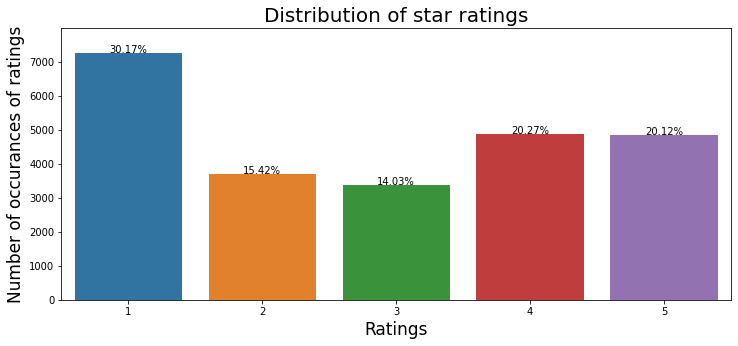

In [18]:
#Distribution of star ratings
total = len(df2)
ax1 = plt.figure(figsize=(12,5))

g = sns.countplot(x=df2['note'], data=df2)
g.set_title("Distribution of star ratings", fontsize=20)
g.set_xlabel("Ratings", fontsize=17)
g.set_ylabel("Number of occurances of ratings", fontsize=17)
sizes = []
for p in g.patches:
    height = p.get_height()
    sizes.append(height)
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=10) 
g.set_ylim(0, max(sizes) * 1.1)

**Most of the users gave rating "1" followed by 4,5,2,3**


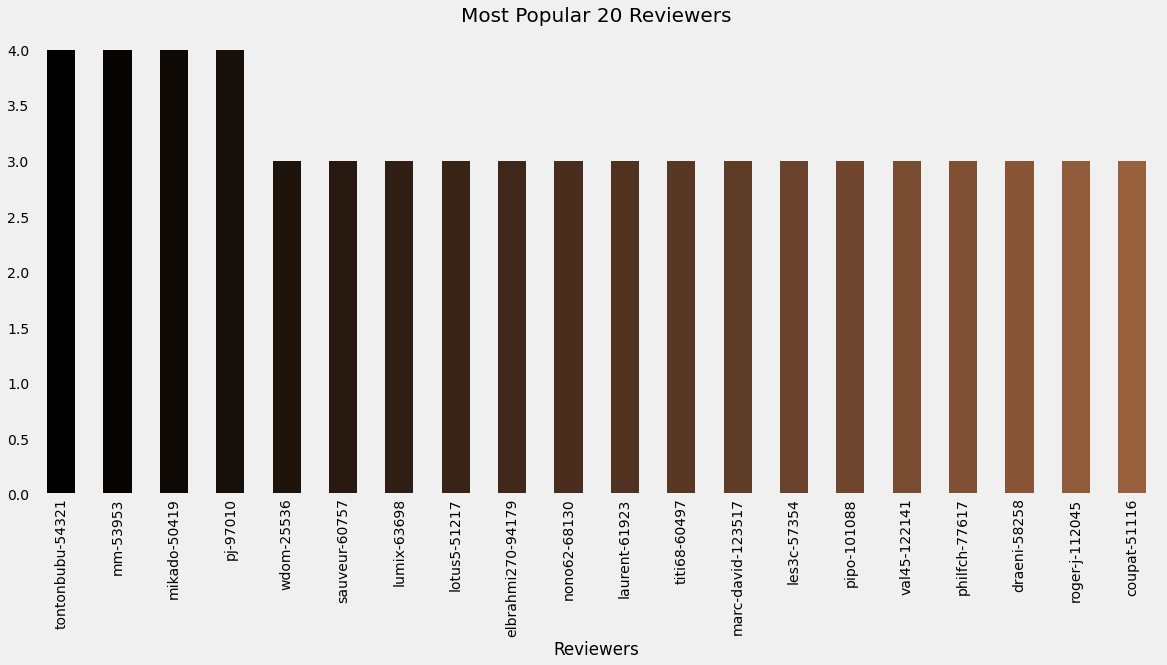

In [19]:
# Most popular 20 reviewers
plt.rcParams['figure.figsize'] = (18, 8)
plt.style.use('fivethirtyeight')

color = plt.cm.copper(np.linspace(0, 2, 80))
df2['auteur'].value_counts().head(20).plot.bar(color = color)
plt.title('Most Popular 20 Reviewers', fontsize = 20, fontweight = 30)
plt.xlabel('Reviewers')
plt.grid()
plt.show()

### Number of reviews per Assureur for each type of insurance

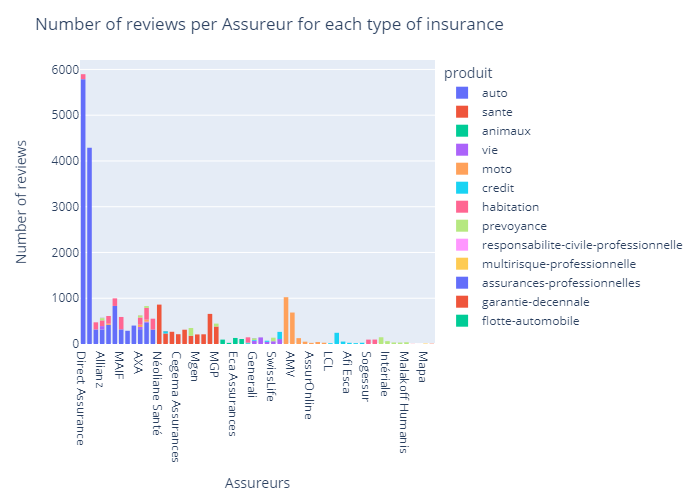

In [20]:
fig = px.histogram(df2, x="assureur",color="produit")
fig.update_layout(
    title_text='Number of reviews per Assureur for each type of insurance', # title of plot
    xaxis_title_text='Assureurs', # xaxis label
    yaxis_title_text='Number of reviews', # yaxis label
    bargap=0.2, 
    bargroupgap=0.1
)
pio.renderers.default = "png"
fig.show("png") # To show the figures on github


- **"Direct Assurance" obtained most of the reviews for the product "auto"**

**Number of reviews per Assureur for each rating**

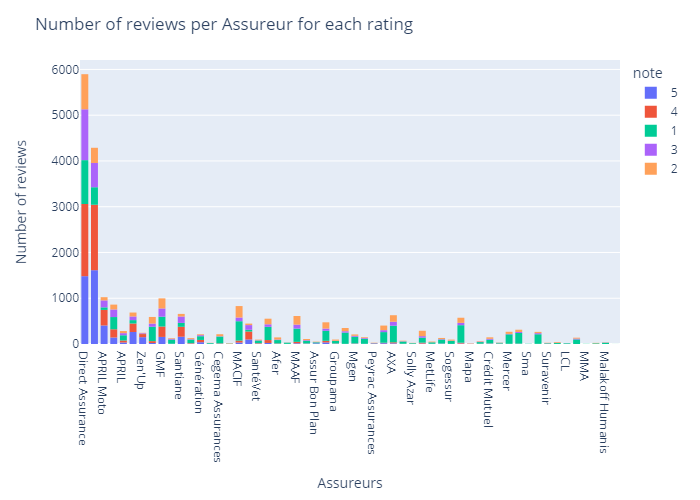

In [21]:
fig = px.histogram(df2, x="assureur",color="note")
fig.update_layout(
    title_text='Number of reviews per Assureur for each rating', # title of plot
    xaxis_title_text='Assureurs', # xaxis label
    yaxis_title_text='Number of reviews', # yaxis label
    bargap=0.2, 
    bargroupgap=0.1
)
pio.renderers.default = "png"
fig.show("png")

- **"Direct Assurance" has obtained highest reviews with mostly 4 star ratings**

### Average ratings per assureur

In [22]:
temp = df2.groupby('assureur').agg({"note": "mean"}).reset_index().round(2)
temp = temp.sort_values("note", ascending = False)

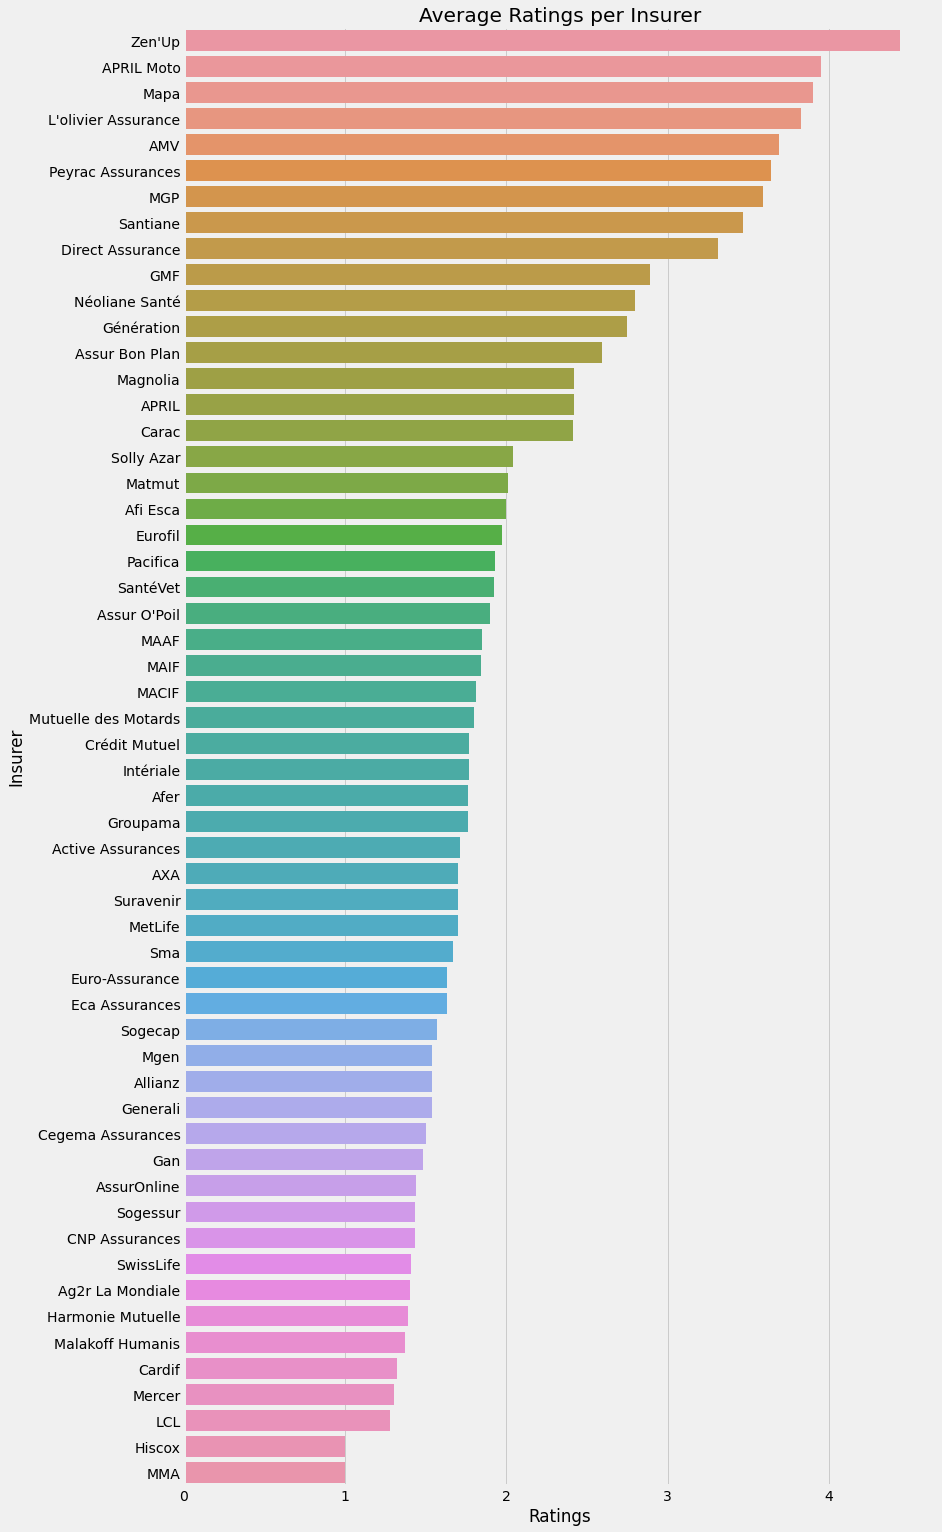

In [23]:
f, axes = plt.subplots(figsize=(12,25))
ax = sns.barplot(y=temp['assureur'],x=temp['note'])
ax.set(title="Average Ratings per Insurer", xlabel="Ratings", ylabel="Insurer")
plt.show()

- **It is observed that "Zen'Up" has highest overall average ratings**


Let's see which type of assurances **Zen'Up** provide along with corresponding ratings

In [24]:
temp1 = df2.groupby(['produit', 'assureur']).agg({"note": "mean"}).reset_index().round(1)
temp1 = temp1.sort_values("note", ascending = False)
temp1

produit             assureur  note
30                                 credit               Zen'Up   4.4
59            multirisque-professionnelle                 Mapa   3.9
48                                   moto           APRIL Moto   3.9
14                                   auto  L'olivier Assurance   3.8
47                                   moto                  AMV   3.7
..                                    ...                  ...   ...
72  responsabilite-civile-professionnelle              Allianz   1.0
31                      flotte-automobile                  AXA   1.0
73  responsabilite-civile-professionnelle               Hiscox   1.0
74  responsabilite-civile-professionnelle                  MMA   1.0
33                     garantie-decennale                  MMA   1.0

[93 rows x 3 columns]

In [25]:
temp1[temp1['assureur']=="Zen'Up"]

produit assureur  note
30  credit   Zen'Up   4.4

- ##### So, we can observe that **Zen'Up** provides credit assurances and has average ratings of **4.4**

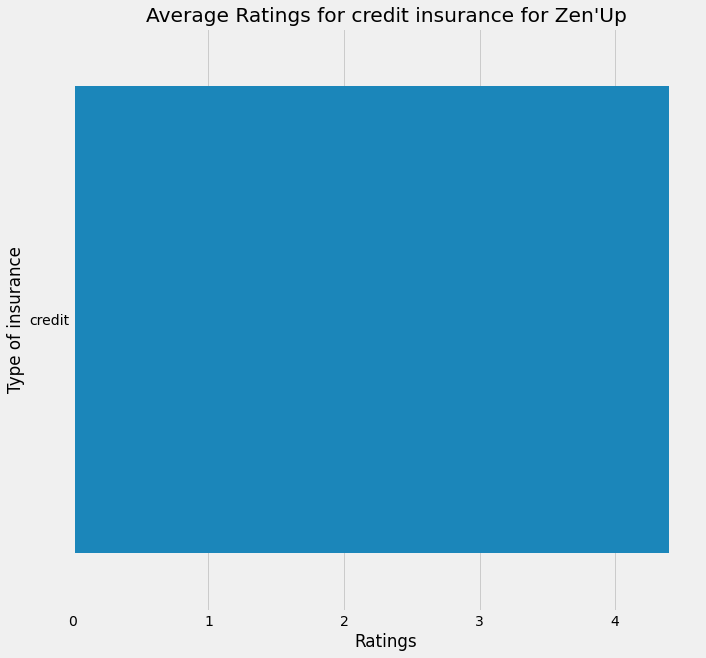

In [26]:
f, axes = plt.subplots(figsize=(10,10))
ax = sns.barplot(y=temp1[temp1['assureur']=="Zen'Up"]['produit'],x=temp1['note'])
ax.set(title="Average Ratings for credit insurance for Zen'Up", xlabel="Ratings", ylabel="Type of insurance")
plt.show()

### Average ratings per type of insurance

In [27]:
tmp = df2.groupby('produit').agg({"note": "mean"}).reset_index().round(2)
tmp = tmp.sort_values("note", ascending = False)
tmp

produit  note
7                                    moto  3.50
2                                    auto  3.15
8             multirisque-professionnelle  2.85
3                                  credit  2.65
11                                  sante  2.53
0                                 animaux  1.82
6                              habitation  1.74
9                              prevoyance  1.66
5                      garantie-decennale  1.58
12                                    vie  1.48
1             assurances-professionnelles  1.25
4                       flotte-automobile  1.00
10  responsabilite-civile-professionnelle  1.00

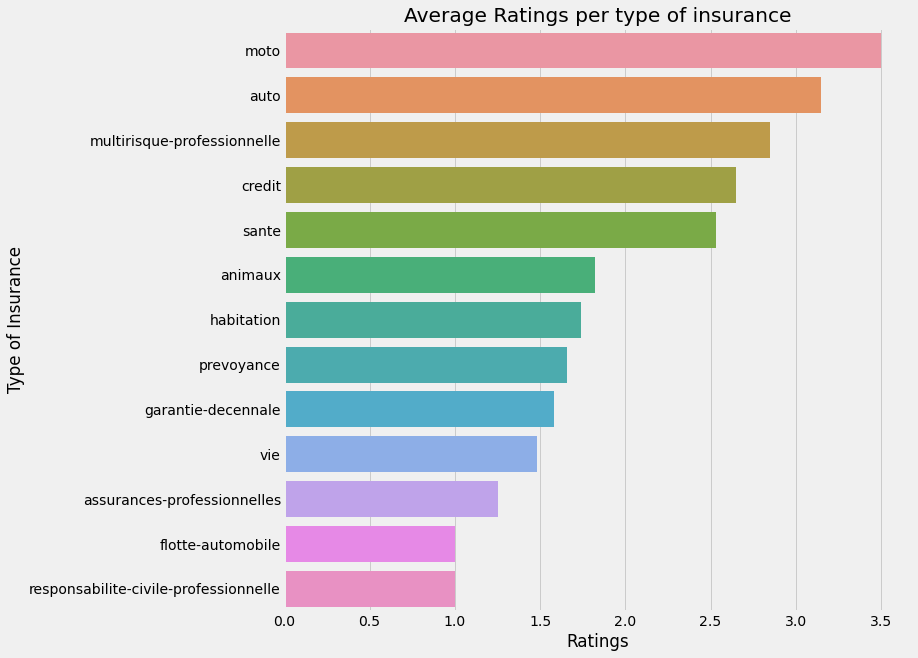

In [28]:
f, axes = plt.subplots(figsize=(10,10))
ax = sns.barplot(y=tmp['produit'],x=tmp['note'])
ax.set(title="Average Ratings per type of insurance", xlabel="Ratings", ylabel="Type of Insurance")
plt.show()

- **We can observe that users have rated the most for motorcycle**

Let's observe which insurer provides highest ratings for motorcyle

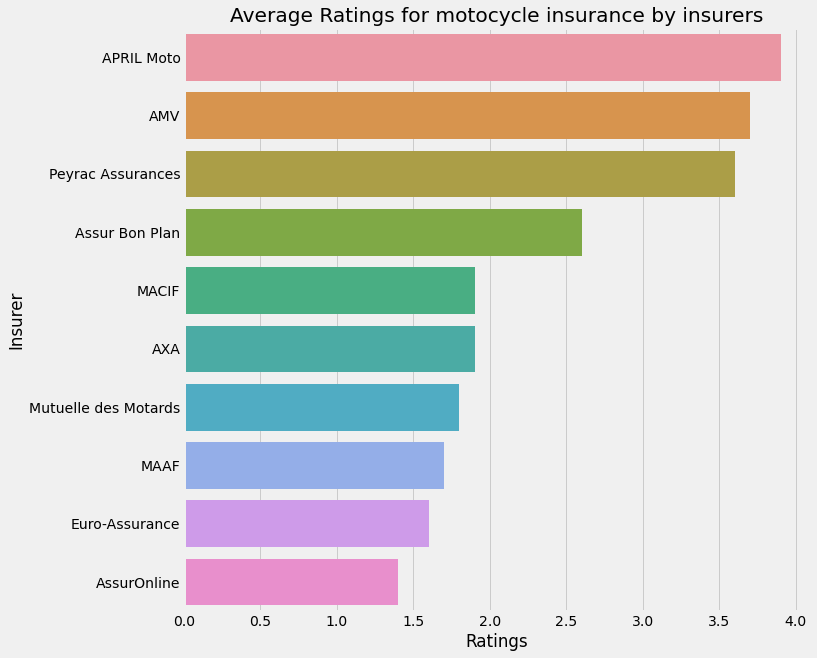

In [29]:
f, axes = plt.subplots(figsize=(10,10))
data = temp1[temp1['produit']=="moto"]
ax = sns.barplot(y=data['assureur'],x=data['note'])
ax.set(title="Average Ratings for motocycle insurance by insurers", xlabel="Ratings", ylabel="Insurer")
plt.show()

 - **We can observe that APRIL Moto has highest average ratings for mototcycle insurance**

In [30]:
# Different types of assurances
c = list(set(df2['produit'].values))
c

['moto',
 'flotte-automobile',
 'credit',
 'multirisque-professionnelle',
 'prevoyance',
 'assurances-professionnelles',
 'animaux',
 'habitation',
 'vie',
 'auto',
 'responsabilite-civile-professionnelle',
 'garantie-decennale',
 'sante']

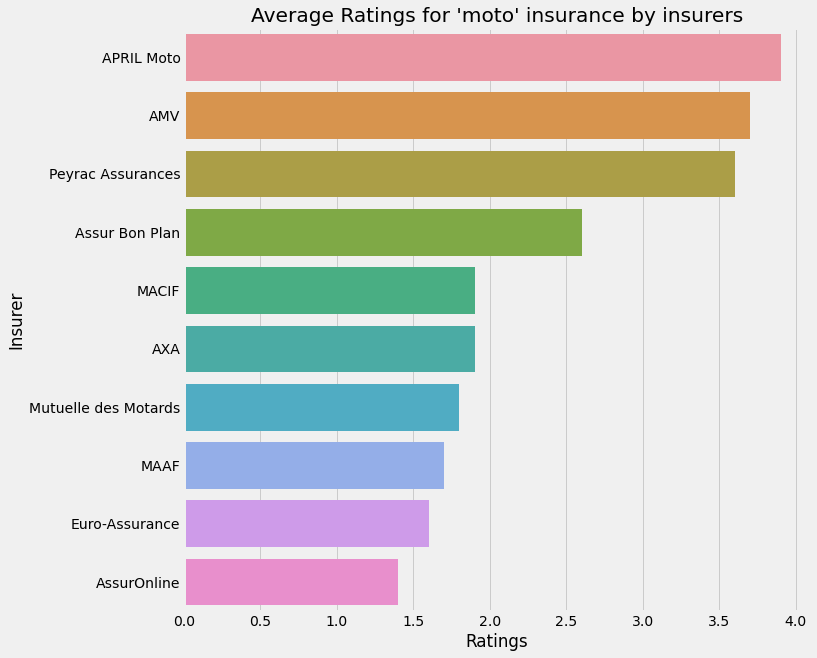

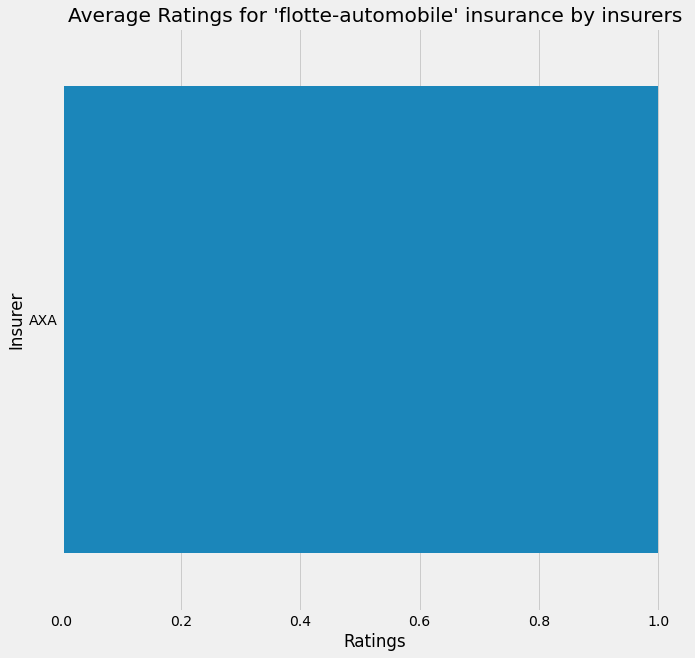

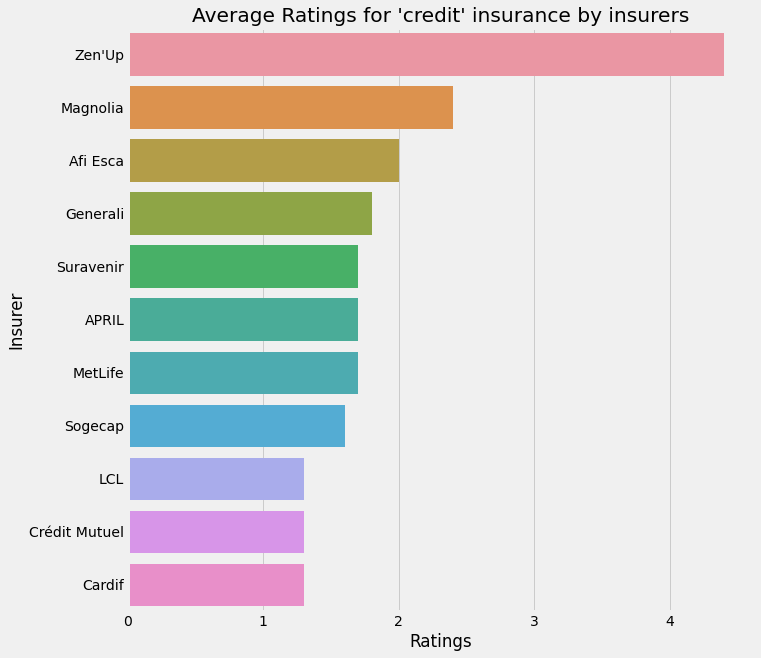

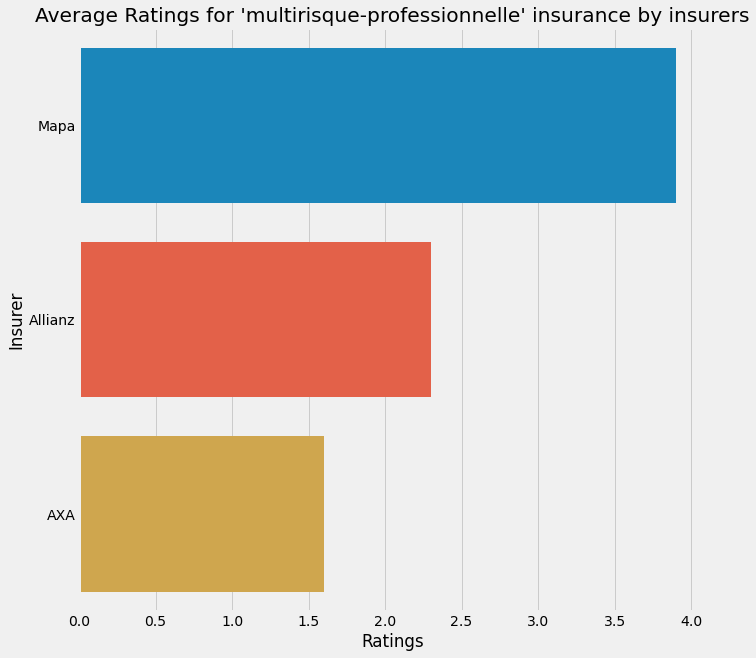

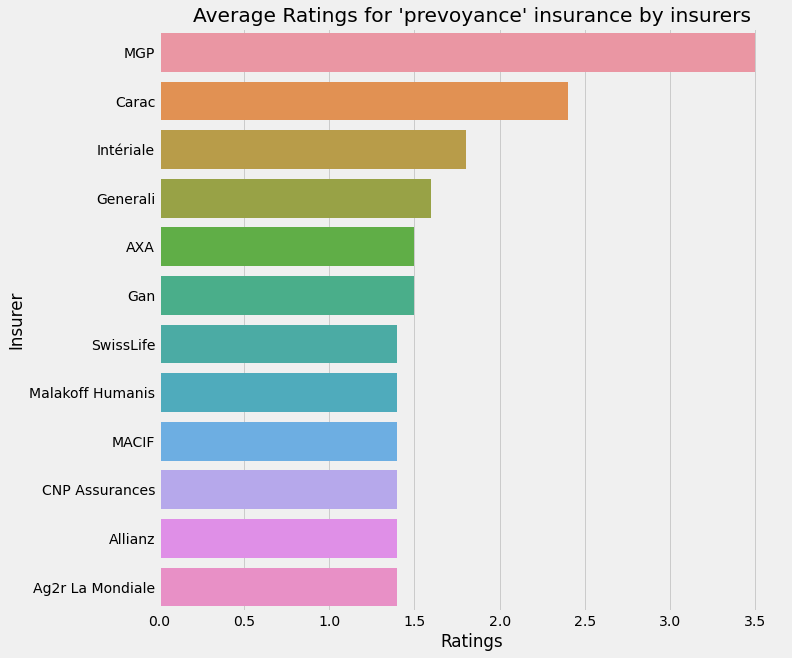

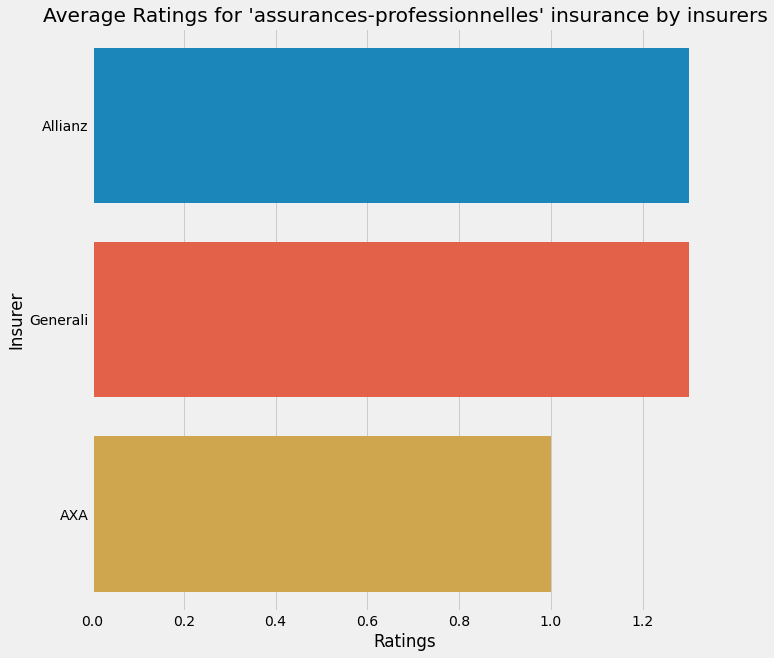

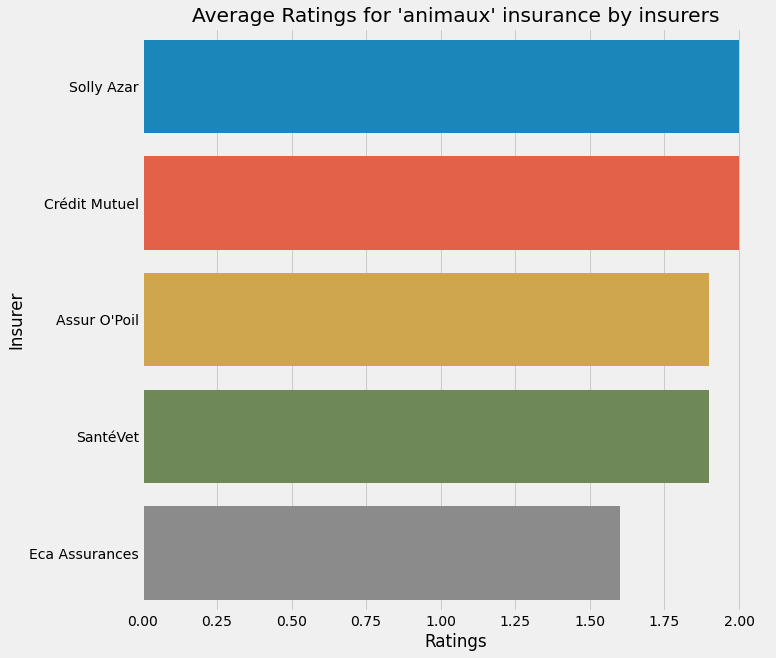

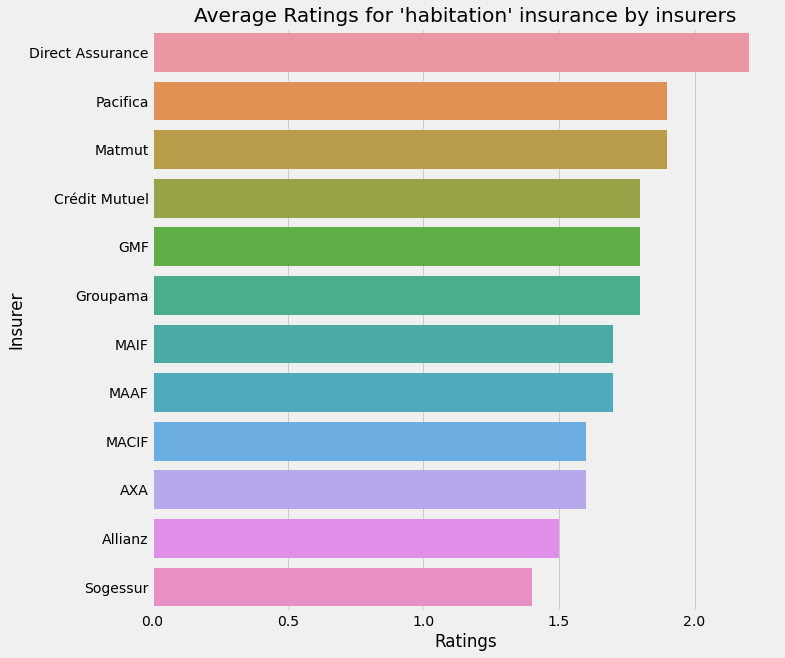

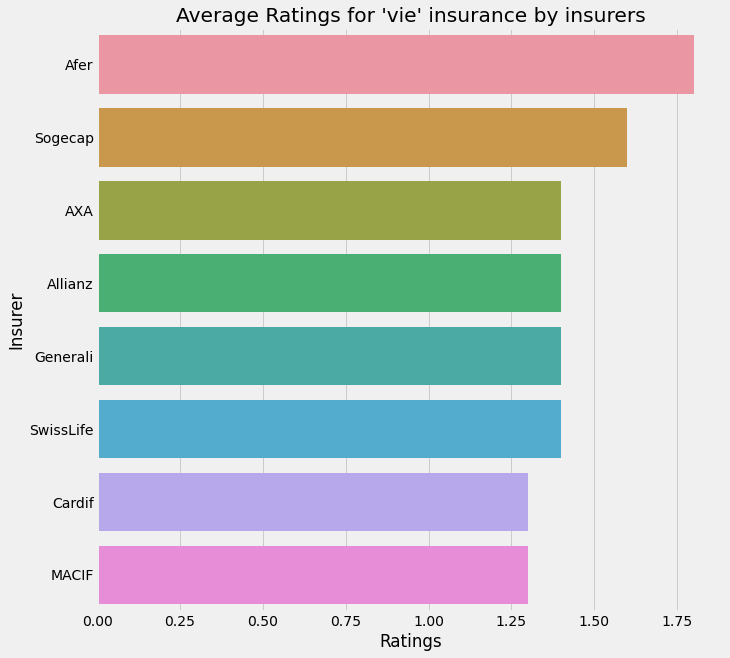

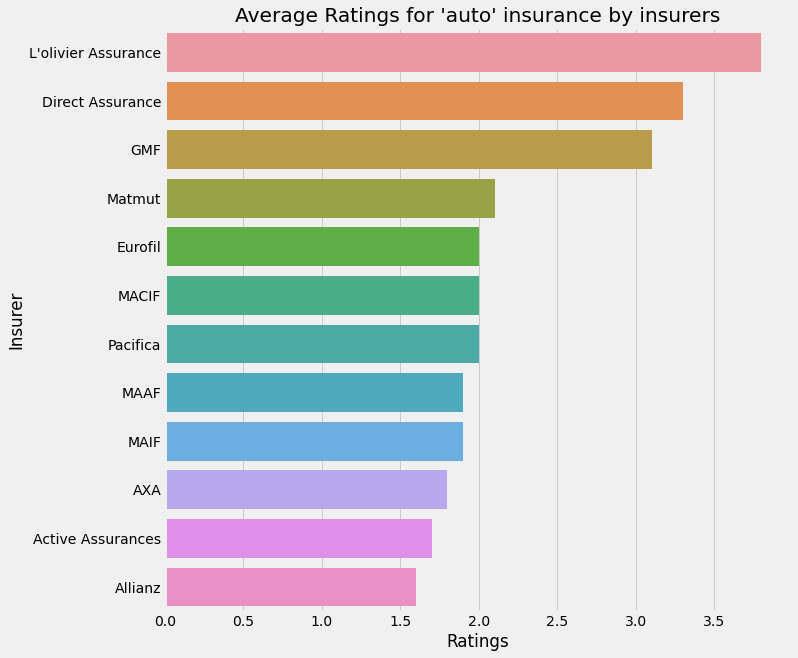

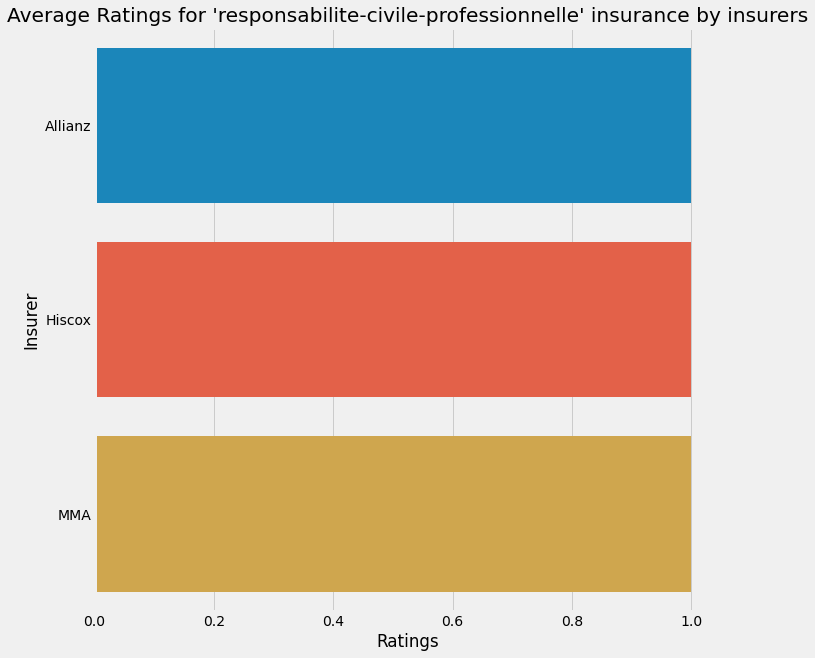

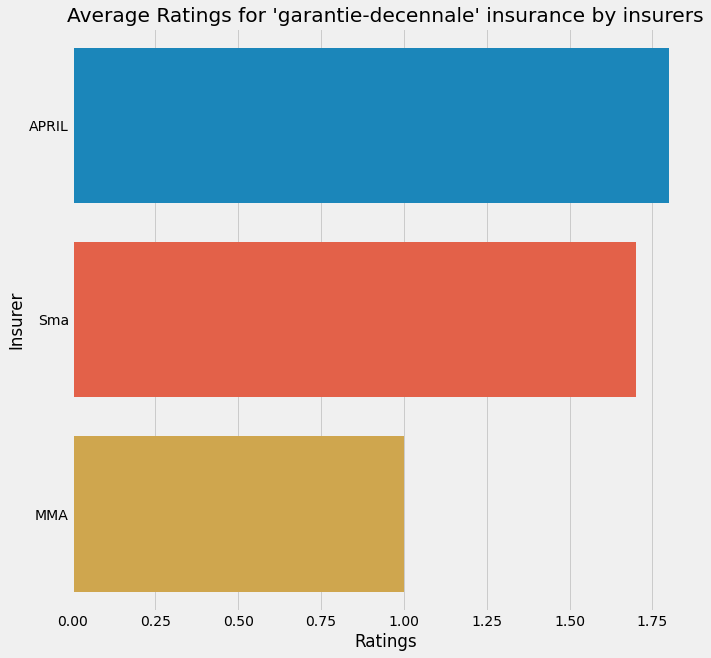

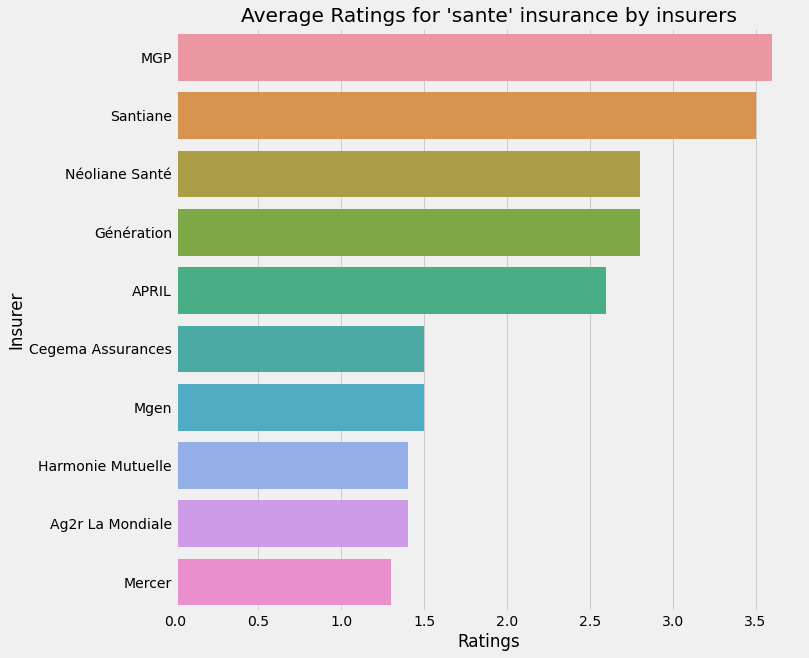

In [31]:
note = []
assur=[]
prd=[]
d={}
for i in c:
    f, axes = plt.subplots(figsize=(10,10))
    data = temp1[temp1['produit']==i]
    ax = sns.barplot(y=data['assureur'],x=data['note'])
    note.append(data.iloc[0]['note'])
    assur.append(data.iloc[0]['assureur'])
    prd.append(data.iloc[0]['produit'])
    title = "Average Ratings for '{}' insurance by insurers".format(i)
    ax.set(title=title, xlabel="Ratings", ylabel="Insurer")
    plt.show()
    
d={'Insurer':assur,'Type of Insurance':prd, 'Rating':note}   


In [32]:
# Combination of type of insurance of insurer with highest average ratings
pd.DataFrame(d)

Insurer                      Type of Insurance  Rating
0            APRIL Moto                                   moto     3.9
1                   AXA                      flotte-automobile     1.0
2                Zen'Up                                 credit     4.4
3                  Mapa            multirisque-professionnelle     3.9
4                   MGP                             prevoyance     3.5
5               Allianz            assurances-professionnelles     1.3
6            Solly Azar                                animaux     2.0
7      Direct Assurance                             habitation     2.2
8                  Afer                                    vie     1.8
9   L'olivier Assurance                                   auto     3.8
10              Allianz  responsabilite-civile-professionnelle     1.0
11                APRIL                     garantie-decennale     1.8
12                  MGP                                  sante     3.6

- For **sante**, **MGP** has highest average rating = **3.6**
- For **animaux**, **Solly Azar** has highest average rating = **2.0**
- For **habitation**, **Direct Assurance** has highest average rating = **2.0**
- For **responsabilite-civile-professionnelle**, **Allianz** has highest average rating = **1.0**
- For **credit**, **Zen'Up** has highest average rating = **4.4**
- For **garantie-decennale**, **APRIL** has highest average rating = **1.8**
- For **assurances-professionnelles**, **Allianz** has highest average rating =  **1.3**
- For **vie**, **Afer** has highest average rating = **1.8**
- For **prevoyance**, **MGP** has highest average rating = **3.5**
- For **multirisque-professionnelle**, **Mapa** has highest average rating = **3.9**
- For **auto**, **L'olivier Assurance** has the highest average rating = **3.8**
- For **moto**, **April Moto** has the highest average rating = **3.9**
- For **flotte-automobile**,  **AXA** has the highest average rating = **1.0**

In [33]:
df2[df2["an"] == 2021]

note              auteur  \
0         5    brahim--k-131532   
1         4    bernard-g-112497   
2         5   virginie-t-107352   
3         4    boulain-f-116580   
6         3    ludovic-b-135966   
...     ...                 ...   
24094     4   moundras-o-108041   
24095     4    thierry-b-123681   
24096     4  christian-l-107138   
24100     1       hophop-107522   
24102     1    jmr-72500-110395   

                                                    avis  \
0      Meilleurs assurances, prix, solutions, écoute,...   
1      je suis globalement satisfait , sauf que vous ...   
2      Prix tres abordable plusieurs options s'offren...   
3      je satisfait du service, une réponse très rapi...   
6      Nouveau client satisfait du prix et des servic...   
...                                                  ...   
24094  Je suis très satisfait de ce service.\r\nLe ta...   
24095  Satisfait de la disponibilité en ligne, inform...   
24096  je suis satisfait du service\r\nsimple et rapi...   
24100  Assurance moto chez la mutuel des motards en F...   
24102  En décembre 2019, j'ai souscrit à un contrat C...   

                   assureur produit   pub_date    an  mois  jour  
0          Direct Assurance    auto 2021-09-06  2021     9     6  
1          Direct Assurance    auto 2021-05-03  2021     5     3  
2          Direct Assurance    auto 2021-03-21  2021     3    21  
3       L'olivier Assurance    auto 2021-06-10  2021     6    10  
6                     APRIL   sante 2021-10-05  2021    10     5  
...                     ...     ...        ...   ...   ...   ...  
24094   L'olivier Assurance    auto 2021-03-25  2021     3    25  
24095            APRIL Moto    moto 2021-07-17  2021     7    17  
24096      Direct Assurance    auto 2021-03-19  2021     3    19  
24100  Mutuelle des Motards    moto 2021-03-22  2021     3    22  
24102     Cegema Assurances   sante 2021-04-14  2021     4    14  

[13383 rows x 9 columns]

### No of reviews published per year

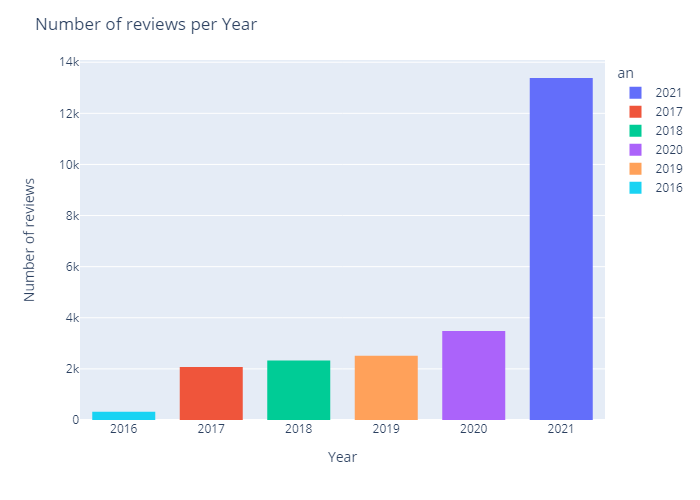

In [34]:
fig = px.histogram(df2, x="an",color="an")
fig.update_layout(
    title_text='Number of reviews per Year', # title of plot
    xaxis_title_text='Year', # xaxis label
    yaxis_title_text='Number of reviews', # yaxis label
    bargap=0.2, 
    bargroupgap=0.1
)
pio.renderers.default = "png"
fig.show("png")

- **We can see that most of the reviews are published recently in 2021**

Let's see in which month of **2021** most of the reviews are published

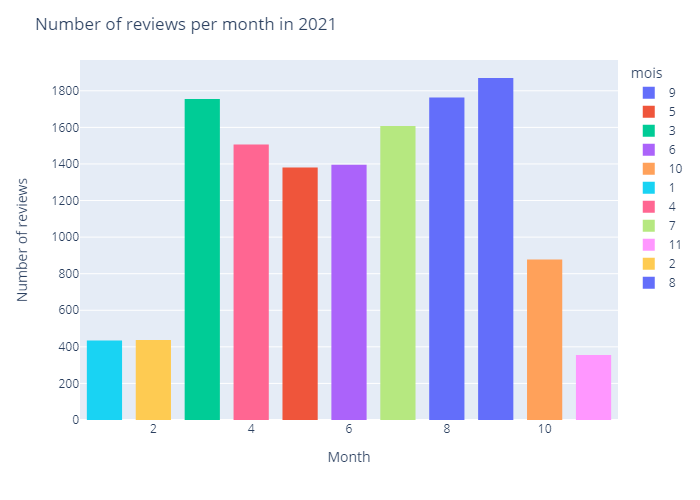

In [35]:
fig = px.histogram(df2[df2['an']==2021], x="mois",color="mois")
fig.update_layout(
    title_text='Number of reviews per month in 2021', # title of plot
    xaxis_title_text='Month', # xaxis label
    yaxis_title_text='Number of reviews', # yaxis label
    bargap=0.2, 
    bargroupgap=0.1
)
pio.renderers.default = "png"
fig.show("png")

- **We can see that most of the reviews are published in sept 2021**

### Let's see which insurer has received more reviews in 2021

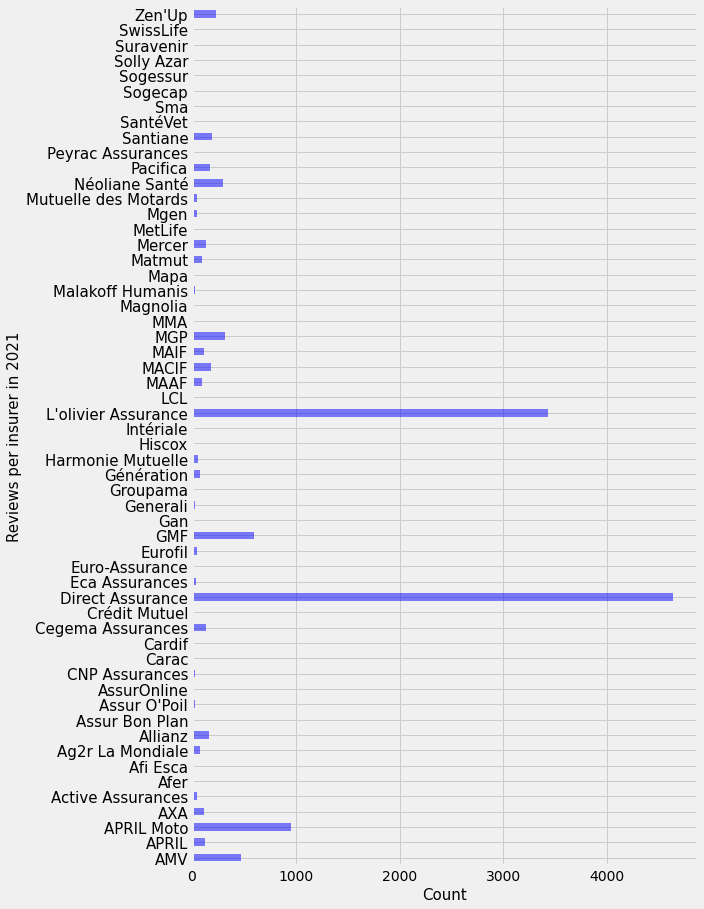

In [36]:
# let's see which insurer has received more reviews in 2021
fig, ax = plt.subplots(figsize=(10, 25))
figure = plt.subplot(2, 1, 2)
pub_an = pd.value_counts(df2[df2['an']==2021]['assureur']).sort_index()
pub_an.plot.barh(alpha = 0.5, color = 'blue')
plt.ylabel('Reviews per insurer in 2021', fontsize = 15)
plt.xlabel('Count', fontsize = 15)
plt.xticks(rotation=0)
plt.yticks(fontsize = 15)
fig.tight_layout()

- **Most of the reviews are published for "Direct Assurance" insurer in 2021**

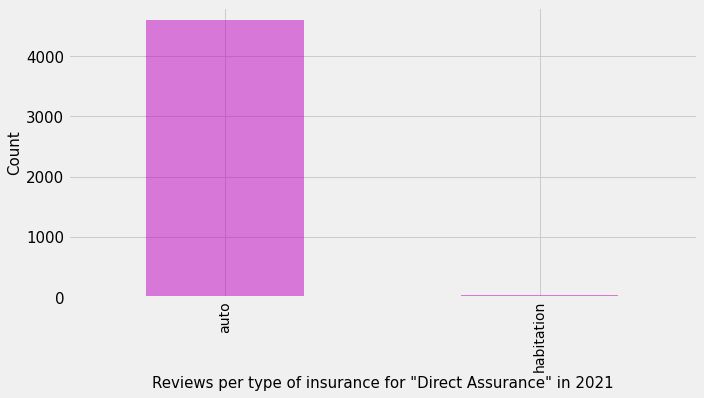

In [37]:
# let's see which for  "Direct Assurance"  which insurance type has received more reviews in 2021
t = df2[df2['an']==2021]
fig, ax = plt.subplots(figsize=(10, 10))
figure = plt.subplot(2, 1, 2)
pub_an = pd.value_counts(t[t['assureur'] == "Direct Assurance"]["produit"]).sort_index()
pub_an.plot.bar(alpha = 0.5, color = 'm')
plt.xlabel('Reviews per type of insurance for "Direct Assurance" in 2021', fontsize = 15)
plt.ylabel('Count', fontsize = 15)
plt.xticks(rotation=90)
plt.yticks(fontsize = 15)
fig.tight_layout()

- **In 2021, most of the reviews are published for "Direct Assurance" insurance company for the product "auto"**

### Sentiment distribution

In [38]:
def get_sentiment(rating):
    if (rating >= 3):
        return "Positive"
    elif (rating < 3) :
        return "Negative"

In [39]:
df2["sentiment"] = df2["note"].apply(get_sentiment) 
df2

note             auteur  \
0         5   brahim--k-131532   
1         4   bernard-g-112497   
2         5  virginie-t-107352   
3         4   boulain-f-116580   
4         1    ouaille31-51798   
...     ...                ...   
24100     1      hophop-107522   
24101     1          tzl-81680   
24102     1   jmr-72500-110395   
24103     3         cris-77532   
24104     1        jesse-51459   

                                                    avis  \
0      Meilleurs assurances, prix, solutions, écoute,...   
1      je suis globalement satisfait , sauf que vous ...   
2      Prix tres abordable plusieurs options s'offren...   
3      je satisfait du service, une réponse très rapi...   
4      Client depuis plus de 25 ans, très déçu de cet...   
...                                                  ...   
24100  Assurance moto chez la mutuel des motards en F...   
24101  Même les demandes les plus simples n'aboutisse...   
24102  En décembre 2019, j'ai souscrit à un contrat C...   
24103  Je suis assurer à la gmf depuis plus de 15 ans...   
24104  Bonjour\r\nMon ami vient de se faire voler sa ...   

                   assureur     produit   pub_date    an  mois  jour sentiment  
0          Direct Assurance        auto 2021-09-06  2021     9     6  Positive  
1          Direct Assurance        auto 2021-05-03  2021     5     3  Positive  
2          Direct Assurance        auto 2021-03-21  2021     3    21  Positive  
3       L'olivier Assurance        auto 2021-06-10  2021     6    10  Positive  
4                    Matmut        auto 2017-01-29  2017     1    29  Negative  
...                     ...         ...        ...   ...   ...   ...       ...  
24100  Mutuelle des Motards        moto 2021-03-22  2021     3    22  Negative  
24101               Allianz  habitation 2019-12-06  2019    12     6  Negative  
24102     Cegema Assurances       sante 2021-04-14  2021     4    14  Negative  
24103                   GMF        auto 2019-07-11  2019     7    11  Positive  
24104                   AMV        moto 2017-01-19  2017     1    19  Negative  

[24103 rows x 10 columns]

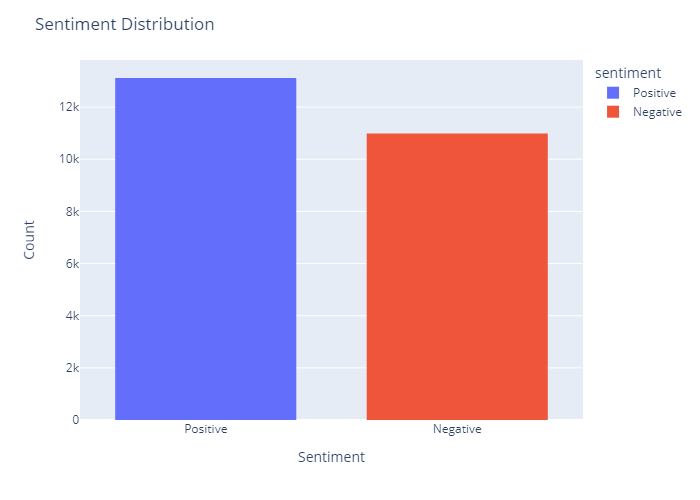

In [40]:
fig = px.histogram(df2, x="sentiment",color="sentiment")
fig.update_layout(
    title_text='Sentiment Distribution', # title of plot
    xaxis_title_text='Sentiment', # xaxis label
    yaxis_title_text='Count', # yaxis label
    bargap=0.2, 
    bargroupgap=0.1
)
pio.renderers.default = "png"
fig.show("png")

In [41]:
df2["sentiment"].value_counts()

Positive    13116
Negative    10987
Name: sentiment, dtype: int64

- **Based on the ratings, it shows that most of the reviews are positive**

### Sentiment distrubution per year

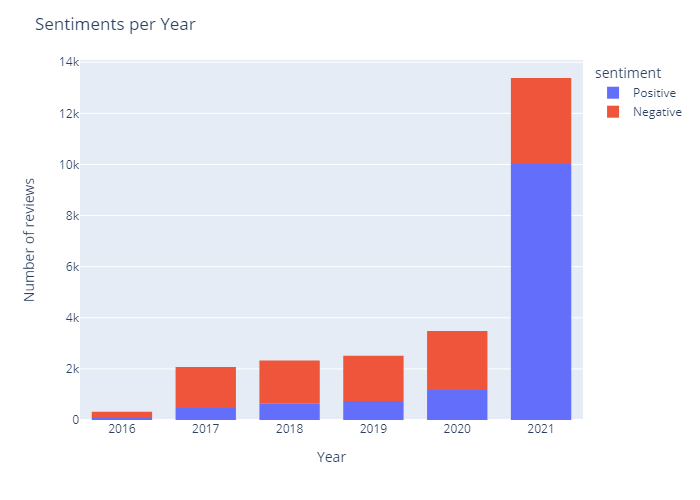

In [42]:
fig = px.histogram(df2, x="an",color="sentiment")
fig.update_layout(
    title_text='Sentiments per Year', # title of plot
    xaxis_title_text='Year', # xaxis label
    yaxis_title_text='Number of reviews', # yaxis label
    bargap=0.2, 
    bargroupgap=0.1
)
pio.renderers.default = "png"
fig.show("png") 

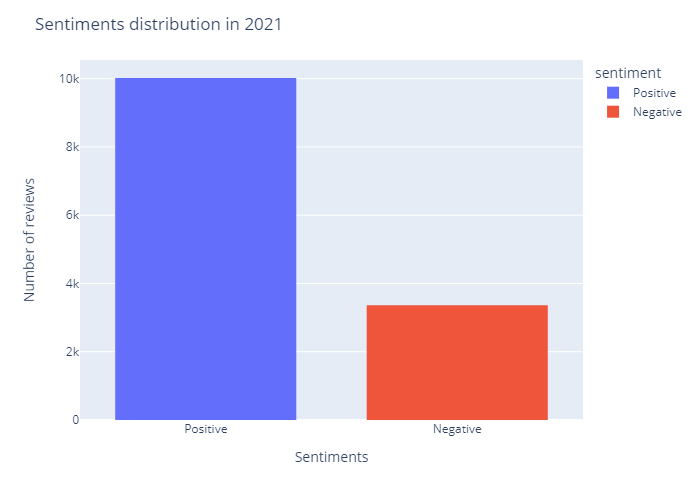

In [43]:
fig = px.histogram(df2[df2['an']==2021], x="sentiment",color="sentiment")
fig.update_layout(
    title_text='Sentiments distribution in 2021', # title of plot
    xaxis_title_text='Sentiments', # xaxis label
    yaxis_title_text='Number of reviews', # yaxis label
    bargap=0.2, 
    bargroupgap=0.1
)
pio.renderers.default = "png"
fig.show("png") 

### Sentiment distribution for each Insurer

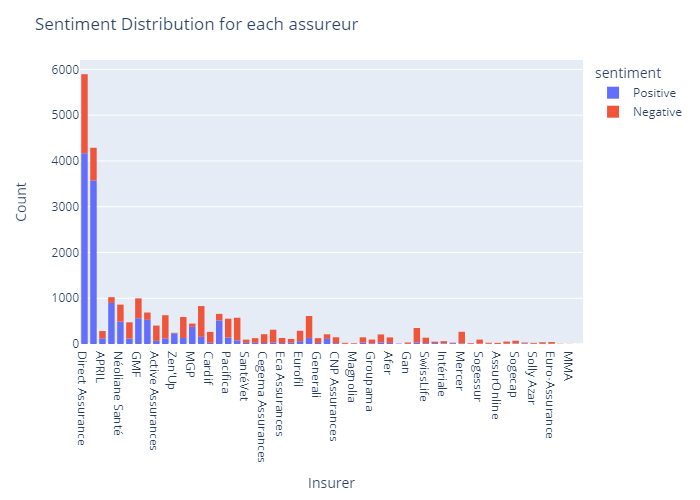

In [44]:
fig = px.histogram(df2, x="assureur",color="sentiment")
fig.update_layout(
    title_text='Sentiment Distribution for each assureur', # title of plot
    xaxis_title_text='Insurer', # xaxis label
    yaxis_title_text='Count', # yaxis label
    bargap=0.2, 
    bargroupgap=0.1
)
pio.renderers.default = "png"
fig.show("png") 

**Direct Assureur has highest number of reviews from which most of them are positive = 4170 and negative = 1726**

### Wordcloud to visualize the frequency of the terms used in reviews

In [45]:
#creation of the stopwords list
stopwords_base = ['là','si','ça','aussi','au','aux','avec','ce','ces','dans','de','des','du','elle','en','et','eux','il','je','la','le','leur','leurs','lui','ma','mais','me','même','mes','moi','mon','ne','nos','notre','nous','on','ou','où','par','pas','pour','qu','que','qui','sa','se','ses','son','sur','ta','te','tes','toi','ton','tu','un','une','vos','votre','vous','ceci','cela','celà','cet','cette','ici','ils','les','leurs','quel','quels','quelle','quelles','sans','soi', 'tout', 'toutes', 'toute', 'tous']
stopwords_punctuation = [',','"',';',':','.','?','!','*','—']
stopwords_letters_only = ['c','d','j','l','à','m','n','s','t','y',"c’","d’","j’","l’","m’","n’","s’","t’","qu’"]
stopwords_etre = ['être','été','étée','étées','étés','étant','suis','es','est','sommes','êtes','sont','serai','seras','sera','serons','serez','seront','serais','serait','serions','seriez','seraient','étais','était','étions','étiez','étaient','fus','fut','fûmes','fûtes','furent','sois','soit','soyons','soyez','soient','fusse','fusses','fût','fussions','fussiez','fussent']
stopwords_avoir = ['a','avoir','ayant','eu','eue','eues','eus','ai','as','avons','avez','ont','aurai','auras','aura','aurons','aurez','auront','aurais','aurait','aurions','auriez','auraient','avais','avait','avions','aviez','avaient','eut','eûmes','eûtes','eurent','aie','aies','ait','ayons','ayez','aient','eusse','eusses','eût','eussions','eussiez','eussent']

#creation of stopset
stopset = stopwords_base
for w in stopwords_punctuation:
    stopset.append(w)

for w in stopwords_letters_only:
    stopset.append(w)

for w in stopwords_avoir:
    stopset.append(w)

for w in stopwords_etre:
    stopset.append(w)
    
# Removing the assureur names    
assureur = list(set(df2['assureur'].values))
for i in range(len(assureur)):

    assureur[i] = assureur[i].lower()
    
assur = ' '.join(assureur).split()

# Removing the product names    
produit = list(set(df2['produit'].values))
for i in range(len(produit)):

    produit[i] = produit[i].lower()
    
prod = ' '.join(produit).split()

#NLTK stop words
STOPWORDS_nltk = nltk.corpus.stopwords.words("french")
stop_words =  assur + prod
stop_words += STOPWORDS_nltk+ stopset +list(fr_stop)+ ['n\'','aucun','ni','aucune','rien','cas','jamais','décembre','mois','jour','année','euro','ans','jai','jvous','bonjour']
print(stop_words)

['mercer', 'mma', 'cegema', 'assurances', 'eca', 'assurances', 'crédit', 'mutuel', 'mgp', 'maif', 'amv', 'afi', 'esca', 'carac', 'suravenir', 'gan', 'ag2r', 'la', 'mondiale', 'assur', "o'poil", 'axa', 'mapa', 'santiane', 'metlife', 'april', 'moto', 'génération', 'intériale', 'mgen', 'allianz', 'afer', 'harmonie', 'mutuelle', 'active', 'assurances', 'hiscox', 'sogessur', 'néoliane', 'santé', 'matmut', 'april', 'assuronline', 'sogecap', 'gmf', 'santévet', 'direct', 'assurance', 'cnp', 'assurances', 'magnolia', 'eurofil', "l'olivier", 'assurance', 'generali', "zen'up", 'swisslife', 'pacifica', 'solly', 'azar', 'macif', 'cardif', 'mutuelle', 'des', 'motards', 'assur', 'bon', 'plan', 'groupama', 'malakoff', 'humanis', 'peyrac', 'assurances', 'lcl', 'maaf', 'euro-assurance', 'sma', 'moto', 'flotte-automobile', 'credit', 'multirisque-professionnelle', 'prevoyance', 'assurances-professionnelles', 'animaux', 'habitation', 'vie', 'auto', 'responsabilite-civile-professionnelle', 'garantie-decenna

### Removing stop words


In [46]:
# Removing stop words
def clean_text(df, df_column_name, new_col):
    
    #Converting all messages to lowercase
    df[new_col] = df[df_column_name].str.lower()
    
    #Replace email addresses with ' '
    df[new_col] = df[new_col].str.replace(r'^.+@[^\.].*\.[a-z]{2,}$',' ')

    #Replace URLs with ' '
    df[new_col] = df[new_col].str.replace(r'^http\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$',' ')

    #Replace money symbols with ' '
    df[new_col] = df[new_col].str.replace(r'£|\$', ' ')
      
    #Replace 10 digit phone numbers (formats include paranthesis, spaces, no spaces, dashes) with ' '
    df[new_col] = df[new_col].str.replace(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$',' ')

    #Replace numbers with ' '
    df[new_col] = df[new_col].str.replace(r'\d+(\.\d+)?', ' ')

    #Remove punctuation
    df[new_col] = df[new_col].str.replace(r'[^\w\d\s]', ' ')
    df[new_col] = df[new_col].str.replace(r'([^\s\w]|_)+', ' ')

    #Replace whitespace between terms with  ' '
    df[new_col] = df[new_col].str.replace(r'\s+', ' ')

    #Remove leading and trailing whitespace
    df[new_col] = df[new_col].str.replace(r'^\s+|\s+?$', ' ')
    
    #Remove stopwords
    #stop_words =  list(set(df2['produit'].values)) + list(set(df2['assureur'].values))
    #stop_words += set(nltk.corpus.stopwords.words("french") + stopset +list(fr_stop)+ ['n\'','aucun','ni','aucune','rien','cas','jamais']) 
    
    df[new_col] = df[new_col].apply(lambda x: ' '.join(term for term in x.split() if term not in stop_words))

In [47]:
print("Before processing: ")
print(df2['avis'].iloc[-1])
print()
clean_text(df2, 'avis', 'cleaned_avis')
print("After processing: ")
print(df2['cleaned_avis'].iloc[-1])

Before processing: 
Bonjour
Mon ami vient de se faire voler sa moto, cette assurance ne veut pas lui rembourser car moto non conforme au modèle d origine. Pourtant les Infos n ont pas été demandées et la moto achetée dans l état . Cet ami  non initié  et non professionnel ne connaissait pas là conformité originelle de ce modèle. (7000 euros perdus)
Une bonne petite procédure va leur faire  le plus grand bien 

After processing: 
ami vient faire voler veut rembourser non conforme modèle origine pourtant infos demandées achetée état ami non initié non professionnel connaissait conformité originelle modèle euros perdus bonne petite procédure faire grand bien


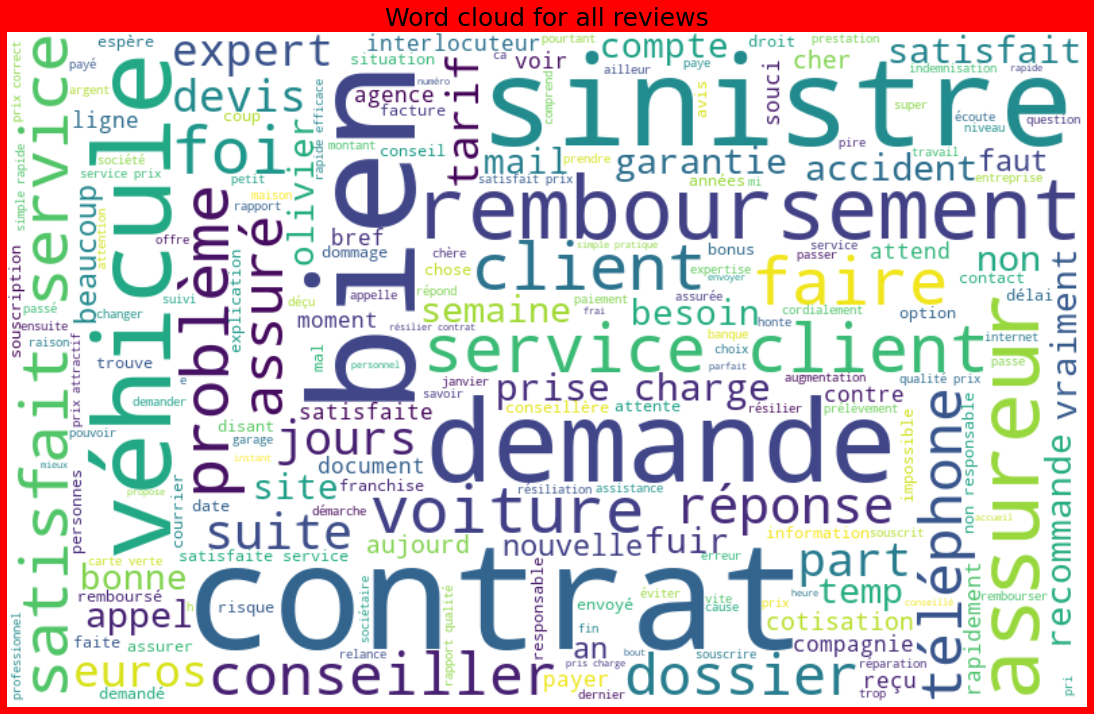

In [48]:
# WordCloud after removing stop words
word_text=(' '.join(df2['cleaned_avis']))
word_cloud = WordCloud(width=800,height=500,background_color='white',stopwords=stop_words,max_font_size=110).generate(word_text)
plt.figure(figsize=(15,12),facecolor='r')
plt.title('Word cloud for all reviews', fontsize = 25)
plt.imshow(word_cloud,interpolation="bilinear")
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

### Lemmatization

In [49]:
# lemmatize french text using spacy & POSTagger
#This allows to bring Lefff lemmatization and part-of-speech tagging to a spaCy custom pipeline.
@Language.factory('french_lemmatizer')
def create_french_lemmatizer(nlp, name):
    return LefffLemmatizer(after_melt=True, default=True)

@Language.factory('melt_tagger')  
def create_melt_tagger(nlp, name):
    return POSTagger()


### Lemmmatization using Spacy

In [50]:
#When POS tagging and Lemmatization are combined inside a pipeline, it improves the text preprocessing for French compared to the built-in spaCy French processing. 
nlp = spacy.load('fr_core_news_sm')
nlp.add_pipe('melt_tagger', after='parser')
nlp.add_pipe('french_lemmatizer', after='melt_tagger')
allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']
doc = nlp(u"meilleurs assurances prix solutions écoute rapidité recommande compagnie prix attractif services qualité rapidité")
for d in doc:
    if(d.pos_ in allowed_postags):
        print(d.text, d.pos_, d._.melt_tagger, d._.lefff_lemma, d.tag_, d.lemma_)

meilleurs NOUN ADJ meilleur NOUN meilleur
assurances NOUN NC assurance NOUN assurance
prix NOUN NC prix NOUN prix
solutions NOUN NC solution NOUN solution
écoute ADJ V écouter ADJ écout
rapidité NOUN NC rapidité NOUN rapidité
recommande VERB V recommander VERB recommande
prix NOUN NC prix NOUN prix
attractif ADJ ADJ attractif ADJ attractif
services NOUN NC service NOUN service
qualité NOUN NC qualité NOUN qualité
rapidité NOUN NC rapidité NOUN rapidité


In [51]:
def lemma(document):
    res = []
    doc = nlp(document)
    for token in doc:
        if token.pos_ in allowed_postags:
            res.append(token.lemma_)
    return res

In [52]:
cl_review = []
for doc in df2['cleaned_avis']:
    cl_review.append(lemma(doc))

In [53]:
cl_review[-1]

['ami',
 'venir',
 'voler',
 'vouloir',
 'rembourser',
 'non',
 'conforme',
 'modèle',
 'origine',
 'pourtant',
 'demander',
 'acheter',
 'état',
 'ami',
 'non',
 'initier',
 'non',
 'professionnel',
 'conformité',
 'originel',
 'modèle',
 'euro',
 'perdu',
 'bon',
 'petit',
 'procédure',
 'faire',
 'grand',
 'bien']

In [54]:
df2

note             auteur  \
0         5   brahim--k-131532   
1         4   bernard-g-112497   
2         5  virginie-t-107352   
3         4   boulain-f-116580   
4         1    ouaille31-51798   
...     ...                ...   
24100     1      hophop-107522   
24101     1          tzl-81680   
24102     1   jmr-72500-110395   
24103     3         cris-77532   
24104     1        jesse-51459   

                                                    avis  \
0      Meilleurs assurances, prix, solutions, écoute,...   
1      je suis globalement satisfait , sauf que vous ...   
2      Prix tres abordable plusieurs options s'offren...   
3      je satisfait du service, une réponse très rapi...   
4      Client depuis plus de 25 ans, très déçu de cet...   
...                                                  ...   
24100  Assurance moto chez la mutuel des motards en F...   
24101  Même les demandes les plus simples n'aboutisse...   
24102  En décembre 2019, j'ai souscrit à un contrat C...   
24103  Je suis assurer à la gmf depuis plus de 15 ans...   
24104  Bonjour\r\nMon ami vient de se faire voler sa ...   

                   assureur     produit   pub_date    an  mois  jour  \
0          Direct Assurance        auto 2021-09-06  2021     9     6   
1          Direct Assurance        auto 2021-05-03  2021     5     3   
2          Direct Assurance        auto 2021-03-21  2021     3    21   
3       L'olivier Assurance        auto 2021-06-10  2021     6    10   
4                    Matmut        auto 2017-01-29  2017     1    29   
...                     ...         ...        ...   ...   ...   ...   
24100  Mutuelle des Motards        moto 2021-03-22  2021     3    22   
24101               Allianz  habitation 2019-12-06  2019    12     6   
24102     Cegema Assurances       sante 2021-04-14  2021     4    14   
24103                   GMF        auto 2019-07-11  2019     7    11   
24104                   AMV        moto 2017-01-19  2017     1    19   

      sentiment                                       cleaned_avis  
0      Positive  meilleurs prix solutions écoute rapidité recom...  
1      Positive  globalement satisfait problème site internet i...  
2      Positive  prix abordable options offrent boitier connect...  
3      Positive  satisfait service réponse rapide service remer...  
4      Negative  client déçu recherche profit immédiat devenu p...  
...         ...                                                ...  
24100  Negative  forte augmentation justificatif réel augmentat...  
24101  Negative  demandes simples aboutissent impossible obteni...  
24102  Negative  souscrit contrat complémentaire vitaneor garan...  
24103  Positive  assurer voler carravanne stationner parc gardi...  
24104  Negative  ami vient faire voler veut rembourser non conf...  

[24103 rows x 11 columns]

In [55]:
df2['cleaned_avis'] = cl_review
df2

note             auteur  \
0         5   brahim--k-131532   
1         4   bernard-g-112497   
2         5  virginie-t-107352   
3         4   boulain-f-116580   
4         1    ouaille31-51798   
...     ...                ...   
24100     1      hophop-107522   
24101     1          tzl-81680   
24102     1   jmr-72500-110395   
24103     3         cris-77532   
24104     1        jesse-51459   

                                                    avis  \
0      Meilleurs assurances, prix, solutions, écoute,...   
1      je suis globalement satisfait , sauf que vous ...   
2      Prix tres abordable plusieurs options s'offren...   
3      je satisfait du service, une réponse très rapi...   
4      Client depuis plus de 25 ans, très déçu de cet...   
...                                                  ...   
24100  Assurance moto chez la mutuel des motards en F...   
24101  Même les demandes les plus simples n'aboutisse...   
24102  En décembre 2019, j'ai souscrit à un contrat C...   
24103  Je suis assurer à la gmf depuis plus de 15 ans...   
24104  Bonjour\r\nMon ami vient de se faire voler sa ...   

                   assureur     produit   pub_date    an  mois  jour  \
0          Direct Assurance        auto 2021-09-06  2021     9     6   
1          Direct Assurance        auto 2021-05-03  2021     5     3   
2          Direct Assurance        auto 2021-03-21  2021     3    21   
3       L'olivier Assurance        auto 2021-06-10  2021     6    10   
4                    Matmut        auto 2017-01-29  2017     1    29   
...                     ...         ...        ...   ...   ...   ...   
24100  Mutuelle des Motards        moto 2021-03-22  2021     3    22   
24101               Allianz  habitation 2019-12-06  2019    12     6   
24102     Cegema Assurances       sante 2021-04-14  2021     4    14   
24103                   GMF        auto 2019-07-11  2019     7    11   
24104                   AMV        moto 2017-01-19  2017     1    19   

      sentiment                                       cleaned_avis  
0      Positive  [meilleur, prix, solution, écout, rapidité, re...  
1      Positive  [globalemer, satisfait, problèm, site, interne...  
2      Positive  [prix, abordable, option, offrir, boitier, con...  
3      Positive  [satisfait, service, réponse, rapide, service,...  
4      Negative  [client, déçu, recherche, profit, immédiat, de...  
...         ...                                                ...  
24100  Negative  [fort, augmentation, justificatif, réel, augme...  
24101  Negative  [demande, simple, aboutissent, impossible, obt...  
24102  Negative  [souscrit, contrat, complémentaire, vitaneor, ...  
24103  Positive  [assurer, voler, carravann, stationner, parc, ...  
24104  Negative  [ami, venir, voler, vouloir, rembourser, non, ...  

[24103 rows x 11 columns]

In [56]:
print(df2['avis'].iloc[-1])
print()
print(df2['cleaned_avis'].iloc[-1])

Bonjour
Mon ami vient de se faire voler sa moto, cette assurance ne veut pas lui rembourser car moto non conforme au modèle d origine. Pourtant les Infos n ont pas été demandées et la moto achetée dans l état . Cet ami  non initié  et non professionnel ne connaissait pas là conformité originelle de ce modèle. (7000 euros perdus)
Une bonne petite procédure va leur faire  le plus grand bien 

['ami', 'venir', 'voler', 'vouloir', 'rembourser', 'non', 'conforme', 'modèle', 'origine', 'pourtant', 'demander', 'acheter', 'état', 'ami', 'non', 'initier', 'non', 'professionnel', 'conformité', 'originel', 'modèle', 'euro', 'perdu', 'bon', 'petit', 'procédure', 'faire', 'grand', 'bien']


### Using WordNetLemmatizer

In [57]:
# Lemmatizing and then Stemming with Snowball to get root words and further reducing characters
#stemmer = SnowballStemmer("french") # Stemmer is not working well!
def lemmatize(text):
    #return stemmer.stem(WordNetLemmatizer().lemmatize(text))
    return WordNetLemmatizer().lemmatize(text)

In [58]:
#Tokenize and Lemmatize
def preprocess(text):
    result=[]
    for token in text:
        if len(token)>=3: # To remove the words like "ok","an","fr","ca","xv"
            result.append(lemmatize(token))
       
    return result

In [59]:
#Processing review with above Function
cleaned_review = []

for doc in df2['cleaned_avis']:
    cleaned_review.append(preprocess(doc))
    
cleaned_review[:3]

[['meilleur',
  'prix',
  'solution',
  'écout',
  'rapidité',
  'recommande',
  'prix',
  'attractif',
  'service',
  'qualité',
  'rapidité'],
 ['globalemer',
  'satisfait',
  'problèm',
  'site',
  'internet',
  'impossible',
  'déclarer',
  'ligne',
  'tentative',
  'déclaration',
  'faire',
  'téléphone',
  'bien',
  'passer',
  'interlocutric',
  'compétent',
  'agréable'],
 ['prix',
  'abordable',
  'option',
  'offrir',
  'boitier',
  'connecter',
  'voiture',
  'option',
  'tranquiliter',
  'zero',
  'franchise',
  'plaire']]

In [60]:
df2['cleaned_avis'] = cleaned_review
df2

note             auteur  \
0         5   brahim--k-131532   
1         4   bernard-g-112497   
2         5  virginie-t-107352   
3         4   boulain-f-116580   
4         1    ouaille31-51798   
...     ...                ...   
24100     1      hophop-107522   
24101     1          tzl-81680   
24102     1   jmr-72500-110395   
24103     3         cris-77532   
24104     1        jesse-51459   

                                                    avis  \
0      Meilleurs assurances, prix, solutions, écoute,...   
1      je suis globalement satisfait , sauf que vous ...   
2      Prix tres abordable plusieurs options s'offren...   
3      je satisfait du service, une réponse très rapi...   
4      Client depuis plus de 25 ans, très déçu de cet...   
...                                                  ...   
24100  Assurance moto chez la mutuel des motards en F...   
24101  Même les demandes les plus simples n'aboutisse...   
24102  En décembre 2019, j'ai souscrit à un contrat C...   
24103  Je suis assurer à la gmf depuis plus de 15 ans...   
24104  Bonjour\r\nMon ami vient de se faire voler sa ...   

                   assureur     produit   pub_date    an  mois  jour  \
0          Direct Assurance        auto 2021-09-06  2021     9     6   
1          Direct Assurance        auto 2021-05-03  2021     5     3   
2          Direct Assurance        auto 2021-03-21  2021     3    21   
3       L'olivier Assurance        auto 2021-06-10  2021     6    10   
4                    Matmut        auto 2017-01-29  2017     1    29   
...                     ...         ...        ...   ...   ...   ...   
24100  Mutuelle des Motards        moto 2021-03-22  2021     3    22   
24101               Allianz  habitation 2019-12-06  2019    12     6   
24102     Cegema Assurances       sante 2021-04-14  2021     4    14   
24103                   GMF        auto 2019-07-11  2019     7    11   
24104                   AMV        moto 2017-01-19  2017     1    19   

      sentiment                                       cleaned_avis  
0      Positive  [meilleur, prix, solution, écout, rapidité, re...  
1      Positive  [globalemer, satisfait, problèm, site, interne...  
2      Positive  [prix, abordable, option, offrir, boitier, con...  
3      Positive  [satisfait, service, réponse, rapide, service,...  
4      Negative  [client, déçu, recherche, profit, immédiat, de...  
...         ...                                                ...  
24100  Negative  [fort, augmentation, justificatif, réel, augme...  
24101  Negative  [demande, simple, aboutissent, impossible, obt...  
24102  Negative  [souscrit, contrat, complémentaire, vitaneor, ...  
24103  Positive  [assurer, voler, carravann, stationner, parc, ...  
24104  Negative  [ami, venir, voler, vouloir, rembourser, non, ...  

[24103 rows x 11 columns]

In [61]:
print(df2["avis"].iloc[-1])
print()
print(df2["cleaned_avis"].iloc[-1])

Bonjour
Mon ami vient de se faire voler sa moto, cette assurance ne veut pas lui rembourser car moto non conforme au modèle d origine. Pourtant les Infos n ont pas été demandées et la moto achetée dans l état . Cet ami  non initié  et non professionnel ne connaissait pas là conformité originelle de ce modèle. (7000 euros perdus)
Une bonne petite procédure va leur faire  le plus grand bien 

['ami', 'venir', 'voler', 'vouloir', 'rembourser', 'non', 'conforme', 'modèle', 'origine', 'pourtant', 'demander', 'acheter', 'état', 'ami', 'non', 'initier', 'non', 'professionnel', 'conformité', 'originel', 'modèle', 'euro', 'perdu', 'bon', 'petit', 'procédure', 'faire', 'grand', 'bien']


In [62]:
df2['cleaned_avis'] = df2['cleaned_avis'].apply(lambda x:' '.join(y for y in x))
df2.head()

note             auteur                                               avis  \
0     5   brahim--k-131532  Meilleurs assurances, prix, solutions, écoute,...   
1     4   bernard-g-112497  je suis globalement satisfait , sauf que vous ...   
2     5  virginie-t-107352  Prix tres abordable plusieurs options s'offren...   
3     4   boulain-f-116580  je satisfait du service, une réponse très rapi...   
4     1    ouaille31-51798  Client depuis plus de 25 ans, très déçu de cet...   

              assureur produit   pub_date    an  mois  jour sentiment  \
0     Direct Assurance    auto 2021-09-06  2021     9     6  Positive   
1     Direct Assurance    auto 2021-05-03  2021     5     3  Positive   
2     Direct Assurance    auto 2021-03-21  2021     3    21  Positive   
3  L'olivier Assurance    auto 2021-06-10  2021     6    10  Positive   
4               Matmut    auto 2017-01-29  2017     1    29  Negative   

                                        cleaned_avis  
0  meilleur prix solution écout rapidité recomman...  
1  globalemer satisfait problèm site internet imp...  
2  prix abordable option offrir boitier connecter...  
3  satisfait service réponse rapide service remer...  
4  client déçu recherche profit immédiat devenir ...

In [63]:
print(df2['avis'].iloc[-1])
print()
print(df2['cleaned_avis'].iloc[-1])

Bonjour
Mon ami vient de se faire voler sa moto, cette assurance ne veut pas lui rembourser car moto non conforme au modèle d origine. Pourtant les Infos n ont pas été demandées et la moto achetée dans l état . Cet ami  non initié  et non professionnel ne connaissait pas là conformité originelle de ce modèle. (7000 euros perdus)
Une bonne petite procédure va leur faire  le plus grand bien 

ami venir voler vouloir rembourser non conforme modèle origine pourtant demander acheter état ami non initier non professionnel conformité originel modèle euro perdu bon petit procédure faire grand bien


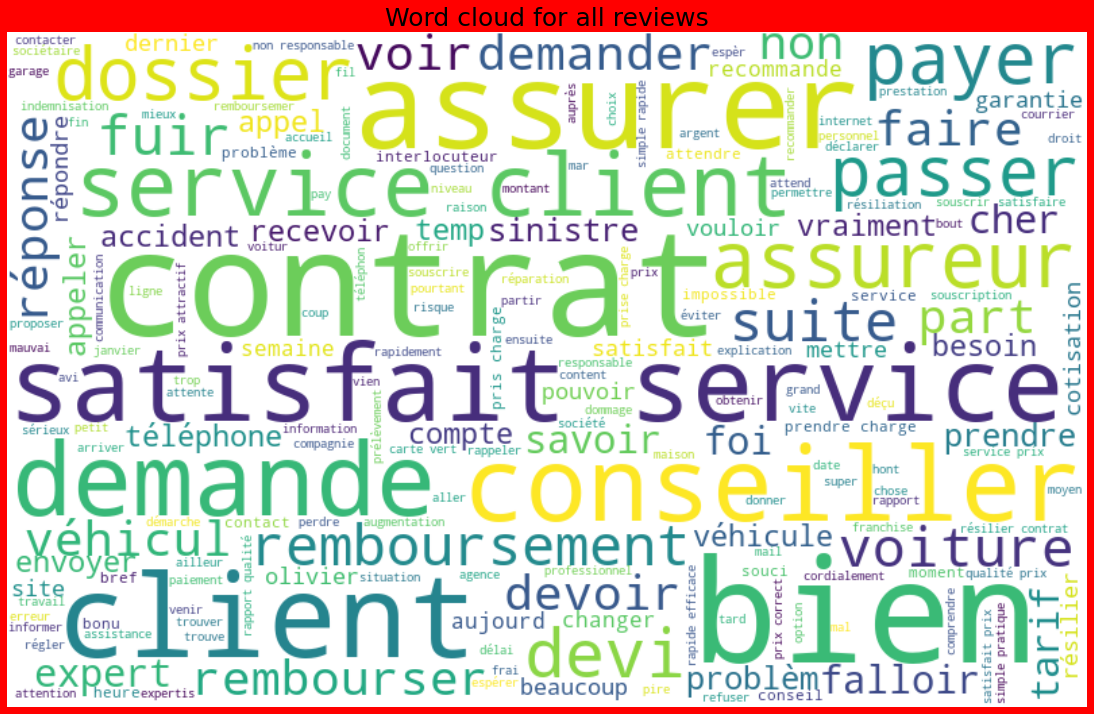

In [64]:
# WordCloud after lemmatization
word_text=(' '.join(df2['cleaned_avis']))
word_cloud = WordCloud(width=800,height=500,background_color='white',stopwords=stop_words,max_font_size=110).generate(word_text)
plt.figure(figsize=(15,12),facecolor='r')
plt.title('Word cloud for all reviews', fontsize = 25)
plt.imshow(word_cloud,interpolation="bilinear")
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [65]:
# Positive reviews
pos = df2[df2['sentiment']=='Positive']
pos_text=(' '.join(pos['cleaned_avis']))
pos_text[0:200]

'meilleur prix solution écout rapidité recommande prix attractif service qualité rapidité globalemer satisfait problèm site internet impossible déclarer ligne tentative déclaration faire téléphone bien'

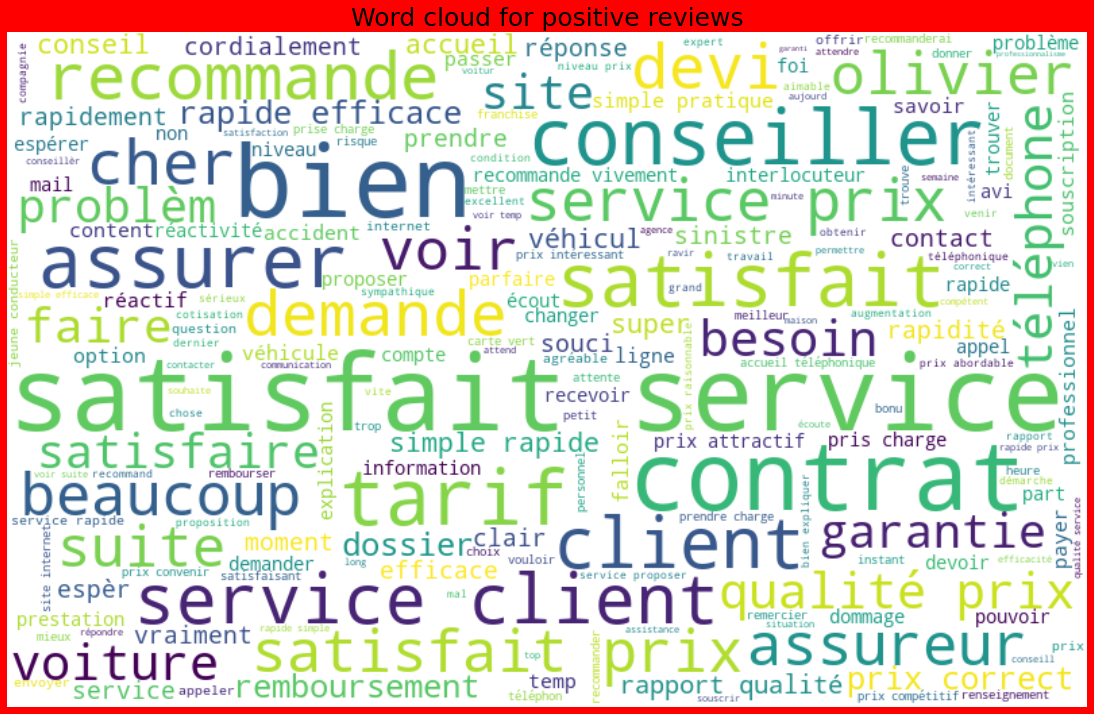

In [66]:
#Word cloud for words in positive ratings
pos_cloud = WordCloud(width=800,height=500,max_font_size=110, background_color='white',stopwords=stop_words).generate(pos_text)

plt.figure(figsize=(15,12),facecolor='r')
plt.title('Word cloud for positive reviews', fontsize = 25)
plt.imshow(pos_cloud,interpolation="bilinear")
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [67]:
#Word cloud for words in negative ratings
neg = df2[df2['sentiment']=='Negative']
neg_text=(' '.join(neg['cleaned_avis']))
neg_text[0:2000]

'client déçu recherche profit immédiat devenir priorité essayer fourguer contrat inutile payer protection juridique contrat défendre moindre défendre contraire mettre office tord descendre bonus trop haut bref boire payer assureur payer besoin vente forcer téléphone évènement grave proche date naissanc faut plateform téléphonique magreb abusif angoisser iscrit bloctel fuir reporter service répression fraude assureur contacté telephone vendr chiot vendant jolis détail souscrit rembourser ensuite vacciner prescrire pommad bouton vet rembours carrence jour parler détail passer tard rappel vaccin chiot chiot achèt vermifuge envoyer euro rembours droit euro frais non souscrire but rembourser appeler résilier bien entendre devoir attendre rétracter chose fuir rejoindre avis négatif regrette devoir mettre étoile service remboursement inexistant attent remboursement optique ostéopathie semaine discour bien roder retard demande traiter fin semaine compter moyenne minute appel conseiller falloir

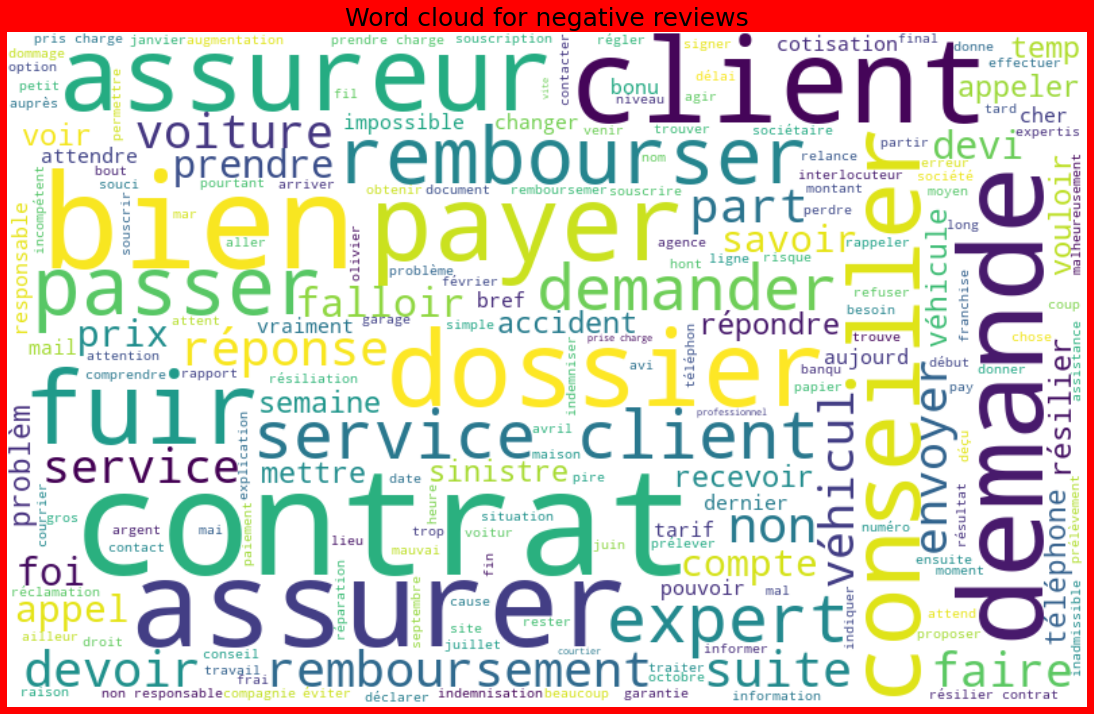

In [68]:
neg_cloud = WordCloud(width=800,height=500,random_state=21, max_font_size=110, background_color='white',stopwords=stop_words).generate(neg_text)

plt.figure(figsize=(15,12),facecolor='r')
plt.title('Word cloud for negative reviews', fontsize = 25)
plt.imshow(neg_cloud,interpolation="bilinear")
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

### 10 most common words

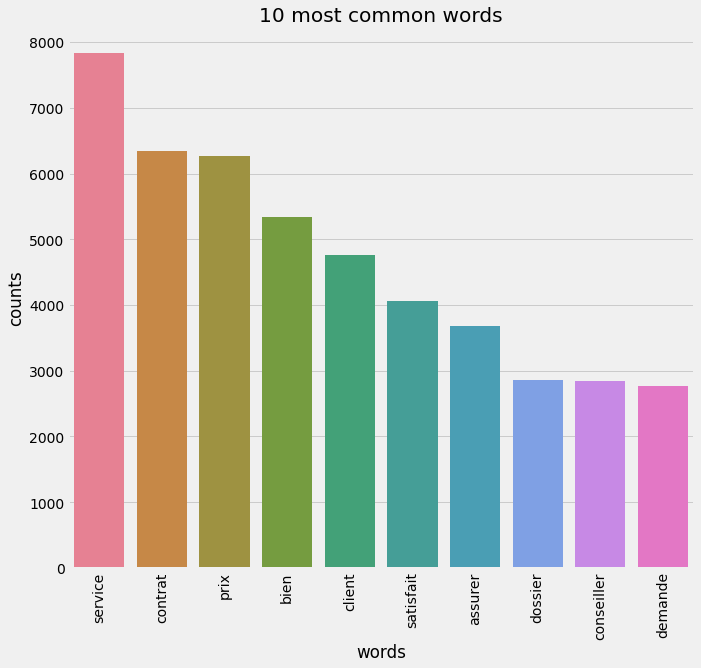

In [69]:
def plot_10_most_common_words(count_data, count_vectorizer):
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(10, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()
# Initialise the count vectorizer with the French stop words
count_vectorizer = CountVectorizer(stop_words=stop_words)
# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(df2.cleaned_avis)
# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

### N-grams Visualization

In [70]:
def get_top_text_ngrams(corpus, n, g):
    vec = CountVectorizer(ngram_range = (g, g)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis = 0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

def plot_most_freq_ngram(n,text):
    most_common_gram = get_top_text_ngrams(text,20,n)
    most_common_gram = dict(most_common_gram)
    temp = pd.DataFrame(columns = ["Common_words" , 'Count'])
    temp["Common_words"] = list(most_common_gram.keys())
    temp["Count"] = list(most_common_gram.values())
    title = "Commmon Words in Ngram"
    if(n==1):
        title = "Top 1grams"
    elif(n==2):
        title = "Top Bigrams"
    elif(n==3):
        title = "Top 3grams"
    fig = px.bar(temp, x = "Count", y = "Common_words", title = title, orientation = 'h', 
                 width = 700, height = 700,color = 'Common_words')
    fig.show()

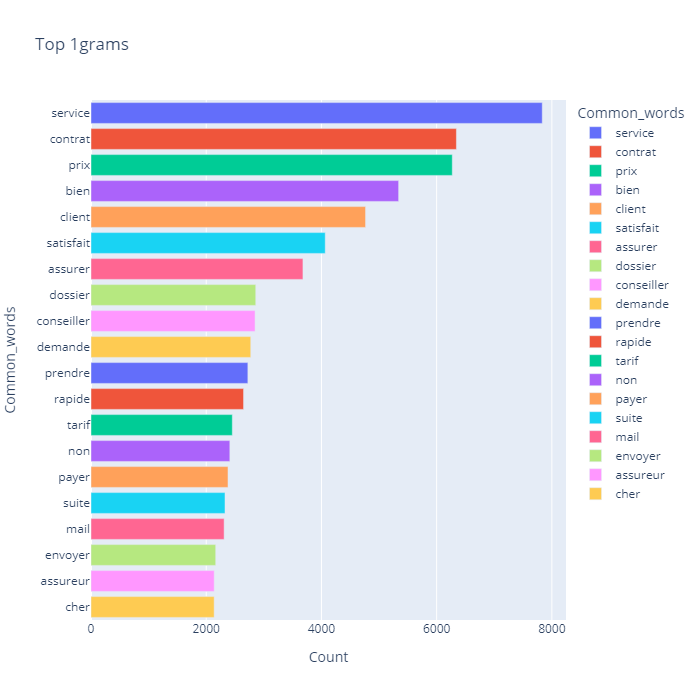

In [71]:
#top 1grams
plot_most_freq_ngram(1,df2['cleaned_avis'])

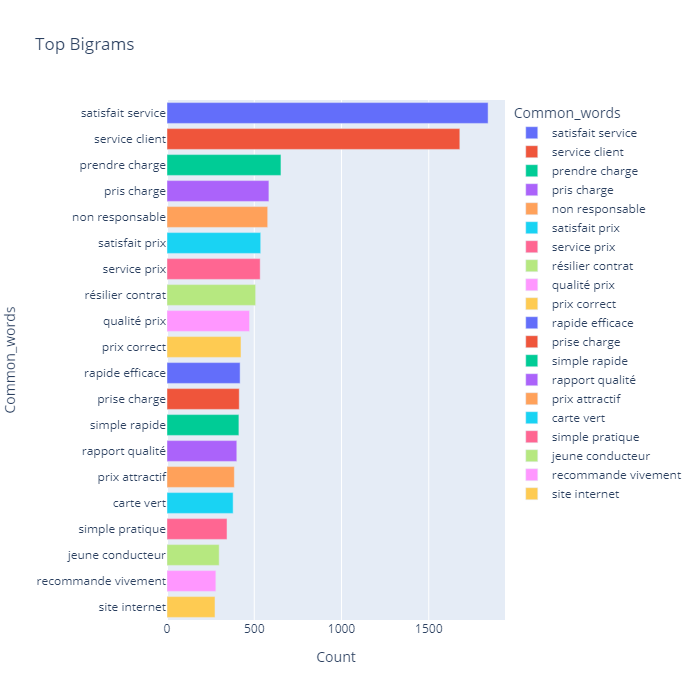

In [72]:
#top bigrams
plot_most_freq_ngram(2,df2['cleaned_avis'])

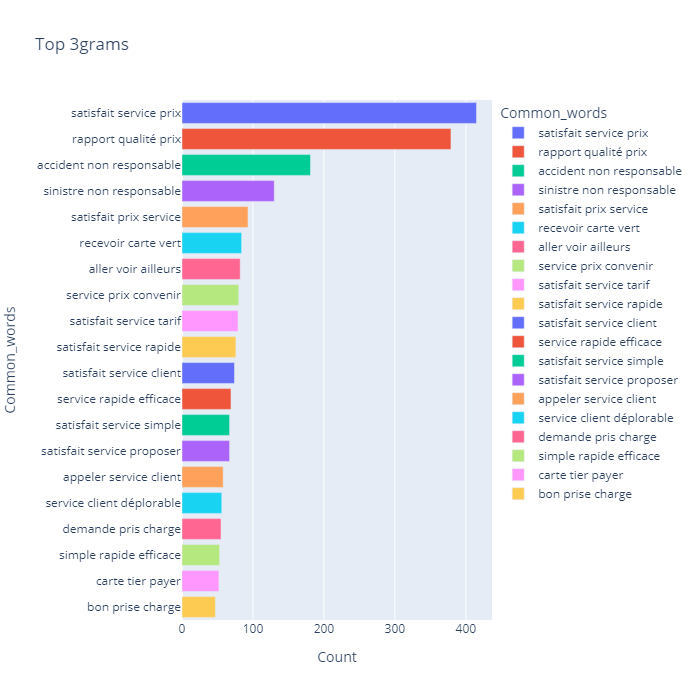

In [73]:
#top 3grams
plot_most_freq_ngram(3,df2['cleaned_avis'])

In [74]:
df2

note             auteur  \
0         5   brahim--k-131532   
1         4   bernard-g-112497   
2         5  virginie-t-107352   
3         4   boulain-f-116580   
4         1    ouaille31-51798   
...     ...                ...   
24100     1      hophop-107522   
24101     1          tzl-81680   
24102     1   jmr-72500-110395   
24103     3         cris-77532   
24104     1        jesse-51459   

                                                    avis  \
0      Meilleurs assurances, prix, solutions, écoute,...   
1      je suis globalement satisfait , sauf que vous ...   
2      Prix tres abordable plusieurs options s'offren...   
3      je satisfait du service, une réponse très rapi...   
4      Client depuis plus de 25 ans, très déçu de cet...   
...                                                  ...   
24100  Assurance moto chez la mutuel des motards en F...   
24101  Même les demandes les plus simples n'aboutisse...   
24102  En décembre 2019, j'ai souscrit à un contrat C...   
24103  Je suis assurer à la gmf depuis plus de 15 ans...   
24104  Bonjour\r\nMon ami vient de se faire voler sa ...   

                   assureur     produit   pub_date    an  mois  jour  \
0          Direct Assurance        auto 2021-09-06  2021     9     6   
1          Direct Assurance        auto 2021-05-03  2021     5     3   
2          Direct Assurance        auto 2021-03-21  2021     3    21   
3       L'olivier Assurance        auto 2021-06-10  2021     6    10   
4                    Matmut        auto 2017-01-29  2017     1    29   
...                     ...         ...        ...   ...   ...   ...   
24100  Mutuelle des Motards        moto 2021-03-22  2021     3    22   
24101               Allianz  habitation 2019-12-06  2019    12     6   
24102     Cegema Assurances       sante 2021-04-14  2021     4    14   
24103                   GMF        auto 2019-07-11  2019     7    11   
24104                   AMV        moto 2017-01-19  2017     1    19   

      sentiment                                       cleaned_avis  
0      Positive  meilleur prix solution écout rapidité recomman...  
1      Positive  globalemer satisfait problèm site internet imp...  
2      Positive  prix abordable option offrir boitier connecter...  
3      Positive  satisfait service réponse rapide service remer...  
4      Negative  client déçu recherche profit immédiat devenir ...  
...         ...                                                ...  
24100  Negative  fort augmentation justificatif réel augmentati...  
24101  Negative  demande simple aboutissent impossible obtenir ...  
24102  Negative  souscrit contrat complémentaire vitaneor garan...  
24103  Positive  assurer voler carravann stationner parc gardie...  
24104  Negative  ami venir voler vouloir rembourser non conform...  

[24103 rows x 11 columns]

In [75]:
df2.to_csv('train_cleaned.csv', index=False, sep=';')

# Unsupervised Learning

###  Bonus: train a word embedding model and analyze similar words and word analogies.

In [76]:
from gensim.models import word2vec
import multiprocessing
import os
from sklearn.metrics.pairwise import cosine_similarity 
import sklearn.manifold

In [77]:
def build_corpus(data):
    "Creates a list of lists containing words from each sentence"
    corpus = []
    for col in ['cleaned_avis']:
        for sentence in df2[col].iteritems():
            word_list = sentence[1].split(" ")
            corpus.append(word_list)
            
    return corpus

corpus = build_corpus(data)        
corpus[0:2]


[['meilleur',
  'prix',
  'solution',
  'écout',
  'rapidité',
  'recommande',
  'prix',
  'attractif',
  'service',
  'qualité',
  'rapidité'],
 ['globalemer',
  'satisfait',
  'problèm',
  'site',
  'internet',
  'impossible',
  'déclarer',
  'ligne',
  'tentative',
  'déclaration',
  'faire',
  'téléphone',
  'bien',
  'passer',
  'interlocutric',
  'compétent',
  'agréable']]

### Create a Word embedding model

In [78]:
#Create Word embedding model
num_features = 300
# Minimum word count threshold.
min_word_count = 3

# Number of threads to run in parallel.
#more workers, faster we train
num_workers = multiprocessing.cpu_count()

# Context window length.
context_size = 7

# Downsample setting for frequent words.
#0 - 1e-5 is good for this
downsampling = 1e-3

# Seed for the RNG, to make the results reproducible.
#random number generator
#deterministic, good for debugging
seed = 713918
model = word2vec.Word2Vec(
    sg=1,
    seed=seed,
    workers=num_workers,
    size=num_features,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling
)

In [79]:
model.build_vocab(corpus)

In [80]:
total_words = len(model.wv.vocab)
print("Word2Vec vocabulary length:", total_words)

Word2Vec vocabulary length: 8694


In [81]:
token_count = sum([len(sentence) for sentence in corpus])
print("The reviews corpus contains {0:,} tokens".format(token_count))

The reviews corpus contains 510,541 tokens


### Training the word embedding model

In [82]:
#Training
model.train(corpus, total_words=token_count, epochs=50)


(22485081, 25527050)

In [83]:
#Save the model
if not os.path.exists("trained"):
    os.makedirs("trained")

model.save(os.path.join("trained", "model.w2v"))

In [84]:
# instantiating and training the Word2Vec model with loss
model_with_loss = word2vec.Word2Vec(
    corpus,
    min_count=1,
    compute_loss=True,
    hs=0,
    sg=1,
    seed=42,
)

# getting the training loss value
training_loss = model_with_loss.get_latest_training_loss()
print(training_loss)

9505862.0


### Explore the trained model


In [85]:
#Explore the trained model
model = word2vec.Word2Vec.load(os.path.join("trained", "model.w2v"))

In [86]:
# extract the words & their vectors, as numpy arrays
vectors = np.asarray(model.wv.vectors)
labels = np.asarray(model.wv.vocab.keys())  # fixed-width numpy strings

### Word similarities

In [87]:
#Explore semantic similarities
#Words closest to the given word
model.wv.most_similar("satisfait")

[('claret', 0.620749831199646),
 ('prix', 0.6038839817047119),
 ('rapide', 0.5769202709197998),
 ('farid', 0.558310866355896),
 ('resonabl', 0.5433135032653809),
 ('exellent', 0.5208097100257874),
 ('satisfit', 0.5172441601753235),
 ('résonnable', 0.515499472618103),
 ('simple', 0.5043635964393616),
 ('resonnabl', 0.4990329444408417)]

In [88]:
model.wv.most_similar("meilleur")

[('farid', 0.37975823879241943),
 ('resonabl', 0.35572606325149536),
 ('nikel', 0.3539600670337677),
 ('merciii', 0.3485339879989624),
 ('contant', 0.3464612662792206),
 ('satisfit', 0.33840447664260864),
 ('asuurance', 0.332988977432251),
 ('résonnable', 0.33065807819366455),
 ('resonnabl', 0.3306381106376648),
 ('parfai', 0.33018630743026733)]

In [89]:
model.wv.most_similar("rembourse")

[('détartrage', 0.3243083953857422),
 ('remplie', 0.3084457516670227),
 ('bordereal', 0.3038652539253235),
 ('remboursable', 0.3005582094192505),
 ('medicament', 0.2989080250263214),
 ('remboursement', 0.2944590747356415),
 ('brulé', 0.2902858853340149),
 ('inscrivez', 0.28599193692207336),
 ('croquette', 0.28495705127716064),
 ('réclament', 0.28369614481925964)]

In [90]:
model.wv.most_similar(positive = ['produit','prix'],negative = ['assureur'],topn = 1)

[('satisfait', 0.40137606859207153)]

In [91]:
pairs = [
    ('satisfait', 'service'),   
    ('satisfait', 'qualité'),  
    ('meilleur', 'service'),  
    ('prix', 'attractif'), 
    ('moto', 'produit'),
]
for w1, w2 in pairs:
    print('%r\t%r\t%.2f' % (w1, w2, model.wv.similarity(w1, w2)))

'satisfait'	'service'	0.45
'satisfait'	'qualité'	0.42
'meilleur'	'service'	0.26
'prix'	'attractif'	0.46
'moto'	'produit'	0.25


In [92]:
print(model.wv.most_similar(positive=['meilleur', 'prix'], topn=5))

[('tarif', 0.5792659521102905), ('farid', 0.5623382329940796), ('satisfait', 0.5504251718521118), ('résonnable', 0.5319435596466064), ('satisfit', 0.5223073363304138)]


# Word Analogies

In [93]:
def word_analogies(a,b,c,word_vectors):
    # Takes three words as input and returns a fourth word which is analogous to the first three
    a,b,c = a.lower(),b.lower(),c.lower()
    words = word_vectors.vocab.keys()
    wa,wb,wc = word_vectors[a],word_vectors[b],word_vectors[c]
    max_sim = -100
    d = None
    for w in words:
        if w in [a,b,c]:
            continue
        wv = word_vectors[w]
        sim1 = cosine_similarity([wb - wa],[wv - wc])
        if sim1>max_sim:
            max_sim = sim1
            d = w
    return d

In [94]:
res=("satisfait","service","prix")
word_analogies(*res,model.wv)

'client'

In [95]:
res=("meilleur","prix","service")
word_analogies(*res,model.wv)

'tarif'

### Find the odd word

In [96]:
# Find the odd word
def odd_one_out(words):
    # Accepts a list of words and returns the odd one out
    word_vec = [model.wv[w] for w in words]
    vec_avg = np.mean(word_vec,axis = 0)
    lst = []
    for z in words:
        sim = cosine_similarity([model.wv[z]],[vec_avg])
        lst.append(sim)
    odd = np.argmin(lst)
    odd_one = words[odd]
    return odd_one

In [97]:
input4 = ["prix","tarif","produit","conseiller"]
odd_one_out(input4)


'conseiller'